# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 1:

>- Juan Pablo Baudoin
>- Fran Cassinese
>- Martin Gruber
>- Mariana Abayay


# Análisis exploratorio

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
from pycountry import languages
from langid.langid import LanguageIdentifier, model

from lib.utils import *
from lib.sim import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Estos paquetes son necesarios para el código (y no vienen instalados por defecto en Anaconda),
# descomentar los módulos que falten para instalarlos:

# !pip install emoji --upgrade --quiet
# !pip install pycountry --upgrade --quiet
# !pip install langdetect --upgrade --quiet
# !pip install pandarallel --upgrade --quiet
# !pip install langid --upgrade --quiet


## 1. Lectura de datos

In [3]:
base_name = "filtered_data_2"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   signal_id         13913 non-null  int64 
 1   source_posted_at  13913 non-null  object
 2   message_text      13913 non-null  object
 3   commodity         13913 non-null  object
 4   trade_type        13902 non-null  object
 5   username          8867 non-null   object
 6   title             13913 non-null  object
 7   chat_id           13913 non-null  int64 
 8   language          13913 non-null  object
dtypes: int64(2), object(7)
memory usage: 978.4+ KB


In [4]:
df_ori.rename(columns={'username':'telegram_user_id'}, inplace=True)

# Creamos una columna id con el índice de la tabla
df_ori['id_msg'] = df_ori.index


In [5]:
df_ori

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg
0,34023,2022-05-05 12:16:04+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... STORJUSD...,STORJ,buy,Scalping_300,Scalping_300%,79,es,0
1,34035,2022-07-03 01:56:33+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... VETUSDT ...,VET,buy,Scalping_300,Scalping_300%,79,es,1
2,17390,2022-10-10 01:39:15+00,Pair : BTCUSDT \nLONG\nLeverage : Cross 20x\nE...,BTC,buy,CryptoCashFlowReal,Crypto Cash flow,101,es,2
3,12833,2022-10-16 19:06:39+00,🥇 #OM (Binance)\n\n🎖Buy Range : 205 - 242\n\n🎯...,OM,buy,bitcoinpumpgroup,Bitcoin Pump Group,5,es,3
4,19038,2022-10-07 05:32:36+00,🌹 #NEO/USDT\n\n🟢 LONG\n\n✅ Entry: 8.45-8.28\n\...,NEO,buy,Gtrading7,GLOBAL TRADING 🌍🌍,206,es,4
...,...,...,...,...,...,...,...,...,...,...
13908,1145165,2022-11-02 18:45:49+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13908
13909,1145214,2022-10-29 01:38:18+00,CAPTION: LONG ⬆️\n\nMKR USDT\n\nENTRY: 884.3\n...,MKR,buy,BybitItalian,Bybit Italiano,3745,es,13909
13910,1145295,2022-11-02 17:35:21+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13910
13911,1473076,2022-09-17 02:39:05+00,⚡️ #MATIC/USDT\n\n🟢 Long\n\n💠 LEVERAGE : 20x\n...,MATIC,buy,CoinExGlobalArabic,CoinEx Arabic-تداول الكريبتو بكل سهولة,4041,es,13911


In [6]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

df.info()
# rename username column


File data/filtered_data_2_enhanced.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13

In [7]:
df

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr
0,135776,2022-01-10 21:34:46+00,#LTO/USDT (Binance)\n\nBuy zone: 0.3147-0.3229...,LTO,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,3472,2022-01-10 21:34:46+00:00,#lto/usdt (binance)\n\nbuy zone: 0.3147-0.3229...,ascii,#lto/usdt (binance)\nbuy zone: 0.3147-0.3229\n...,193,31,8
1,139072,2022-01-24 19:24:09+00,#UNFI/BTC (Binance)\n\nBuy zone: 17134-17585\n...,UNFI,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,1748,2022-01-24 19:24:09+00:00,#unfi/btc (binance)\n\nbuy zone: 17134-17585\n...,ascii,#unfi/btc (binance)\nbuy zone: 17134-17585\nta...,218,34,9
2,139305,2022-01-30 16:45:11+00,#NAV/BTC (Binance)\n\nBuy zone: 459-472\n\n🎯 T...,NAV,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,5960,2022-01-30 16:45:11+00:00,#nav/btc (binance)\n\nbuy zone: 459-472\n\n ta...,ascii,#nav/btc (binance)\nbuy zone: 459-472\ntarget ...,171,31,8
3,140058,2022-02-01 18:30:18+00,#AMB/BTC (Binance)\n\nBuy zone: 82-85\n\n🎯 Tar...,AMB,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,4125,2022-02-01 18:30:18+00:00,#amb/btc (binance)\n\nbuy zone: 82-85\n\n targ...,ascii,#amb/btc (binance)\nbuy zone: 82-85\ntarget 1:...,198,34,9
4,138481,2022-02-03 21:56:06+00,#BTS/BTC (Binance)\n\nBuy zone: 60-61\n\n🎯 Tar...,BTS,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,4095,2022-02-03 21:56:06+00:00,#bts/btc (binance)\n\nbuy zone: 60-61\n\n targ...,ascii,#bts/btc (binance)\nbuy zone: 60-61\ntarget 1:...,196,34,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13908,1144890,2022-11-06 20:54:53+00,CAPTION: SHORT ⬇️\n\nADA USDT\n\nENTRY: 0.4237...,ADA,buy,BybitItalian,Bybit Italiano,3745,es,13847,2022-11-06 20:54:53+00:00,caption: short \n\nada usdt\n\nentry: 0.4237\n...,ascii,caption: short\nada usdt\nentry: 0.4237\ntp 1:...,75,15,5
13909,1301876,2022-05-09 15:08:20+00,I GOT MORE TO UPDATE BUT IMA FINISHED THE UPDA...,SAND,buy,NaN,Glass Ceiling🏴‍☠️⌨️,3846,es,13747,2022-05-09 15:08:20+00:00,i got more to update but ima finished the upda...,ascii,i got more to update but ima finished the upda...,305,65,0
13910,1350457,2022-09-29 14:58:30+00,"Bitcoin target 20500-21000, Ethereum target 14...",BITCOIN,sell,avalanche_zh,Avalanche(AVAX)官方中文群,3872,es,13703,2022-09-29 14:58:30+00:00,"bitcoin target 20500-21000, ethereum target 14...",ascii,"bitcoin target 20500-21000, ethereum target 14...",53,6,0
13911,1473446,2022-03-29 17:09:11+00,CAPTION: Currency: \n#uma\nEntry: $7.95\nTarge...,UMA,buy,CoinExGlobalArabic,CoinEx Arabic-تداول الكريبتو بكل سهولة,4041,es,13912,2022-03-29 17:09:11+00:00,caption: currency: \n#uma\nentry: $7.95\ntarge...,ascii,caption: currency:\n#uma\nentry: $7.95\ntarget...,91,13,4


## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



In [8]:
# group df by id and count the number of rows
df_grouped_id = df.groupby('signal_id').size().reset_index(name='counts')
# sort the values by counts
df_grouped_id = df_grouped_id.sort_values(by='counts', ascending=False)
df_grouped_id

,signal_id,counts
0,10,1
9280,184952,1
9269,184919,1
9270,184922,1
9271,184924,1
...,...,...
4641,59057,1
4642,59067,1
4643,59074,1
4644,59085,1


### 2.1 Nulos

In [9]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columns with missing values
    telegram_user_id: 36.27%
    trade_type: 0.08%
############
Columns with no missing values
    signal_id
    source_posted_at
    message_text
    commodity
    title
    chat_id
    language
    id_msg


In [10]:
# Excluir los registros sin chat_id
df = df.dropna(subset=['chat_id'])
df = df.dropna(subset=['message_text'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

## Filtado de mensajes en ingles

In [11]:
# List the languages in the datase language column
languages = df['language'].unique()
print(languages)


['es']


In [12]:
# filter the messages with language 'en'
# flt_en = df['language'] == 'en'
flt_en = df['language'] == 'es'
df = df[flt_en]

print(f"Numero de mensajes en ingles: {df.shape[0]}")

Numero de mensajes en ingles: 13913


### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [13]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - BTC: 557 	 (4.0% - 4.00%)
02 - ETH: 388 	 (2.79% - 6.79%)
03 - LTC: 235 	 (1.69% - 8.48%)
04 - BNB: 218 	 (1.57% - 10.05%)
05 - DYDX: 214 	 (1.54% - 11.59%)
06 - TRX: 213 	 (1.53% - 13.12%)
07 - GALA: 194 	 (1.39% - 14.51%)
08 - AXS: 181 	 (1.3% - 15.81%)
09 - YFI: 173 	 (1.24% - 17.05%)
10 - MATIC: 163 	 (1.17% - 18.22%)
11 - MASK: 162 	 (1.16% - 19.38%)
--------
Top 11 Canal (chat_id):
01 - 79: 2599 	 (18.68% - 18.68%)
02 - 169: 2409 	 (17.31% - 35.99%)
03 - 101: 1427 	 (10.26% - 46.25%)
04 - 5: 1134 	 (8.15% - 54.40%)
05 - 180: 870 	 (6.25% - 60.65%)
06 - 71: 723 	 (5.2% - 65.85%)
07 - 2131: 440 	 (3.16% - 69.01%)
08 - 78: 416 	 (2.99% - 72.00%)
09 - 66: 378 	 (2.72% - 74.72%)
10 - 206: 290 	 (2.08% - 76.80%)
11 - 2269: 283 	 (2.03% - 78.83%)
--------
Top 11 Users (telegram_user_id):
01 - N/A: 5046 	 (36.27%  - 36.27%) 	 (NaN)
02 - Scalping_300: 2599 	 (18.68%  - 54.95%) 	 (W/NaN 29.31% - 29.31%)
03 - CryptoCashFlowReal: 1427 	 (10.26%  - 65.21%) 	 

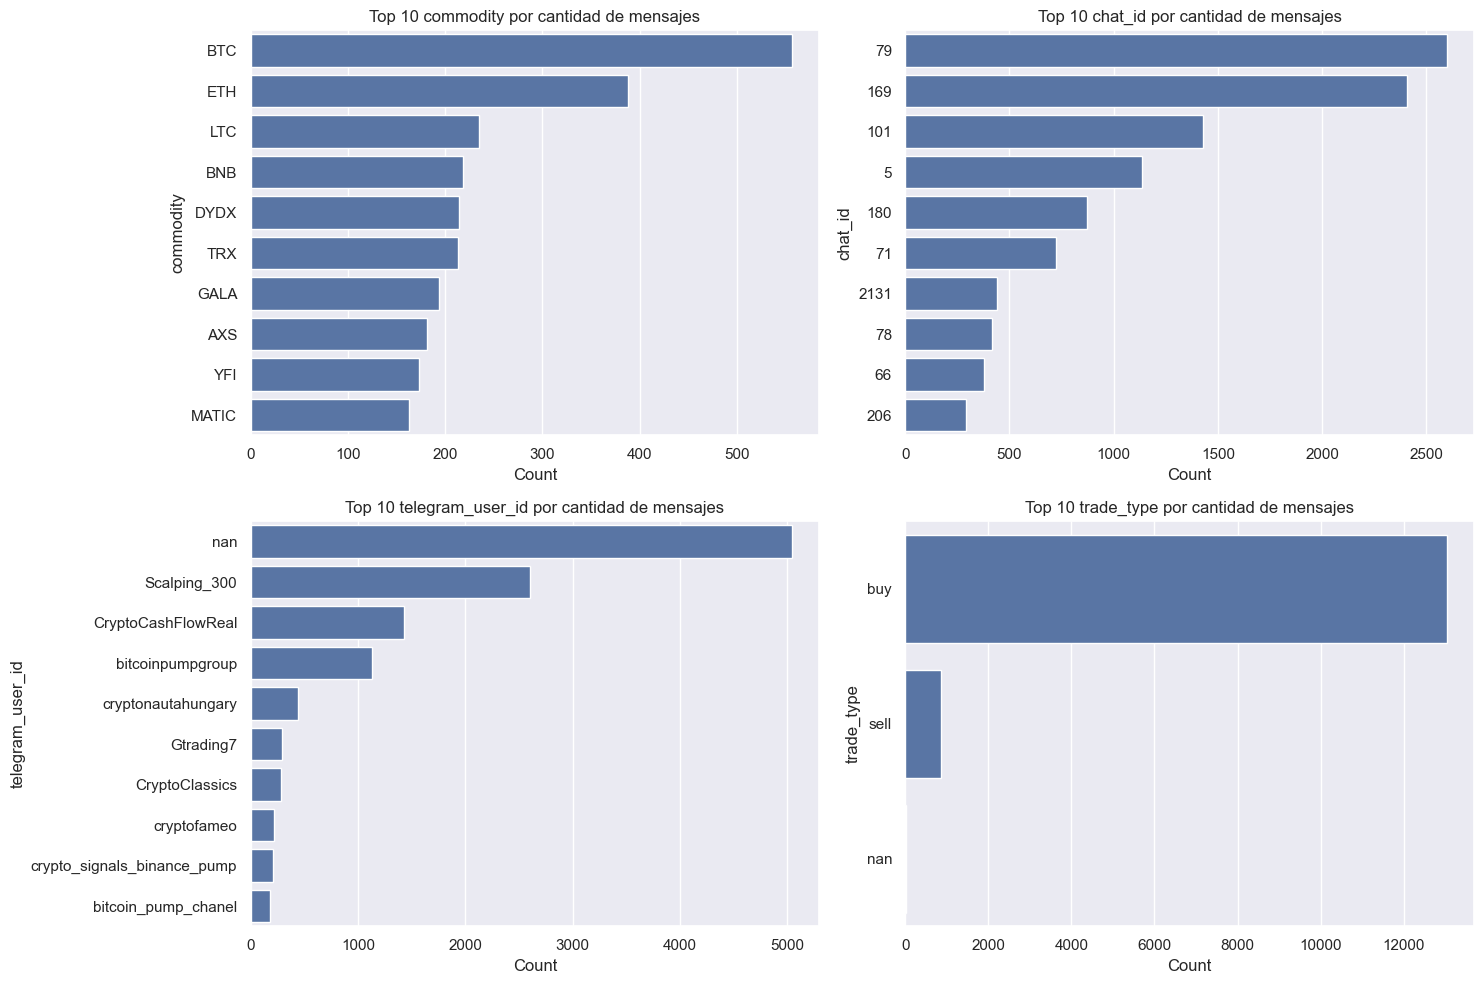

In [14]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [15]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")



Number of chat_ids: 128
Number of users: 110


In [16]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()} ({single_user_chats.count()/chat_ids:.2%})")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()} ({single_chat_users.count()/users:.2%})")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 110 (85.94%)
Number of users with a single chat: 110 (100.00%)


In [17]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 0
Number of chats with more than one user: 0.00%
Series([], Name: telegram_user_id, dtype: int64)
--------
Number of users with more than one chat: 0
Number of users with more than one chat: 0.00%
Series([], Name: chat_id, dtype: int64)


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8


In [18]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break

    # df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply
    # (lambda x: '\n'.join(line.strip() for line in x.splitlines() if line.strip()))

    try:
        cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text
    

In [19]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################

    # Eliminar emojis y añadir columna message_no_emoji
    print("Cleaning Emojis")
    df['message_text_clean'] = df['message_text'].parallel_apply(remove_emojis).str.strip().str.lower()

    # # Detect the encoding of messages in the field message_text_clean of type string\
    print("Detecting encoding")
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    print("Convert to utf-8")
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    # print("Detecting encoding on new utf-8 messages")
    # df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Trim and remove multiple line breaks
    print("Cleaning LBR")
    df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply(clean_lbr)

    # Añadir columna con la longitud del mensaje sin emojis
    print("Checking message length")
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    print("Checking message words")
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)

    print("Store the processed data")
    df.to_csv(work_file, index=False)


In [20]:
# find messages with a length of 0
zero_length = df['message_length'] == 0
print(f"Number of messages with a length of 0: {zero_length.sum()}")

# drop messages with a length of 0
df = df[~zero_length]
df.to_csv(work_file, index=False)


Number of messages with a length of 0: 0


#### 2.3.3. Mensajes duplicados

In [21]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 7341
Percentage of duplicated messages: 52.76%
--------


In [22]:
duplicated_messages.head(5)['id_msg']

595      4720
600      6022
8809     2428
8810     8611
8987    12850
Name: id_msg, dtype: int64

Si vemos mensajes duplicados en una ventana pequeña de tiempo podemos asumir que son el mismo mensaje y quedarnos con uno.

In [23]:
# repeated_window
repeated_window = 1 # Window where to consider repeated messages within the same chat_id a repeated messaged

df = df.sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at'])

# Group by chat_id and find the time difference between consecutive messages
# df['time_diff'] = df.groupby('chat_id', 'message_text_clean_utf8')['date_source_posted_at'].diff()
df['time_diff'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['date_source_posted_at'].diff()


# Mark duplicates as those with a time difference less than 5 minutes (300 seconds) and the same message text
df['duplicates'] = df['message_text_clean_utf8'].duplicated(keep=False)
df['duplicate_count'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['id_msg'].transform('count')
df['duplicates_near'] = (df['time_diff'] <= pd.Timedelta(minutes=repeated_window)) & (df['message_text_clean_utf8'].duplicated(keep='first'))




cols_check = ['chat_id', 'date_source_posted_at', 'message_text_clean_utf8', 'time_diff', 'duplicates', 'duplicates_near', 'duplicate_count']
df[cols_check].sort_values(by=['chat_id', 'date_source_posted_at']).head(10)

# Keep only the first message in the case of duplicates
# df_filtered = df[~df['duplicate']]

# Drop helper columns if not needed
# df_filtered = df_filtered.drop(columns=['time_diff', 'duplicate'])

# count the number of duplicates_near
duplicates_near = df['duplicates_near'].sum()
print(f"Number of duplicates_near: {duplicates_near}")
print(f"Percentage of duplicates_near: {duplicates_near/df.shape[0]:.2%}")


Number of duplicates_near: 3385
Percentage of duplicates_near: 24.33%


In [24]:
# Remove duplicates_near
df = df[~df['duplicates_near']]

#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

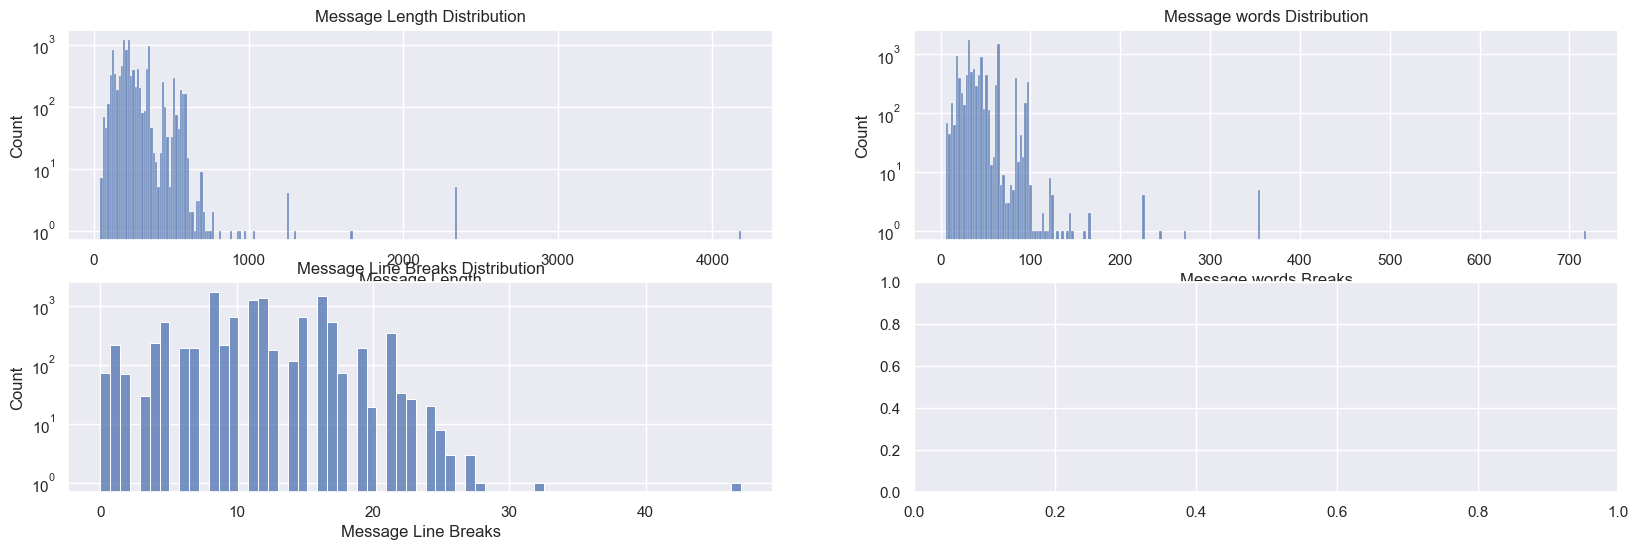

In [25]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [26]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,10528.000000,10528.000000,10528.000000
mean,266.318199,44.719605,11.519377
std,143.568089,24.094271,4.674633
min,42.000000,6.000000,0.000000
25%,187.000000,31.000000,8.000000
50%,222.000000,38.000000,11.000000
75%,348.000000,61.000000,16.000000
max,4185.000000,719.000000,47.000000


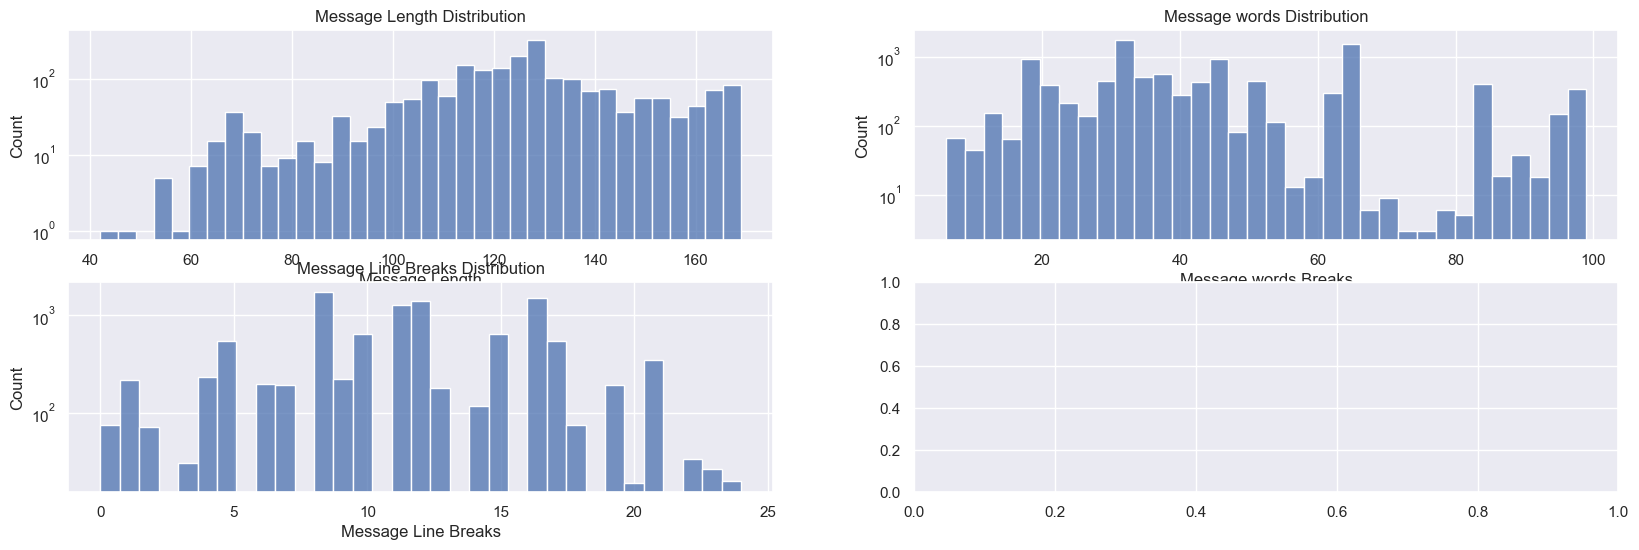

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = (df['message_lbr'] < 25) & (df['message_lbr'] >= 0) 
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

In [28]:
print_top(df, 'message_lbr', "LBR", top=21)

Top 21 LBR (message_lbr):
01 - 8: 1740 	 (16.53% - 16.53%)
02 - 16: 1504 	 (14.29% - 30.82%)
03 - 12: 1385 	 (13.16% - 43.98%)
04 - 11: 1281 	 (12.17% - 56.15%)
05 - 10: 640 	 (6.08% - 62.23%)
06 - 15: 639 	 (6.07% - 68.30%)
07 - 5: 544 	 (5.17% - 73.47%)
08 - 17: 541 	 (5.14% - 78.61%)
09 - 21: 344 	 (3.27% - 81.88%)
10 - 4: 234 	 (2.22% - 84.10%)
11 - 9: 220 	 (2.09% - 86.19%)
12 - 1: 217 	 (2.06% - 88.25%)
13 - 6: 197 	 (1.87% - 90.12%)
14 - 7: 191 	 (1.81% - 91.93%)
15 - 19: 190 	 (1.8% - 93.73%)
16 - 13: 179 	 (1.7% - 95.43%)
17 - 14: 118 	 (1.12% - 96.55%)
18 - 0: 74 	 (0.7% - 97.25%)
19 - 18: 74 	 (0.7% - 97.95%)
20 - 2: 71 	 (0.67% - 98.62%)
21 - 22: 33 	 (0.31% - 98.93%)


In [29]:
print_top(df, 'message_words', "Words", top=80)

Top 80 Words (message_words):
01 - 64: 1428 	 (13.56% - 13.56%)
02 - 32: 1196 	 (11.36% - 24.92%)
03 - 46: 828 	 (7.86% - 32.78%)
04 - 19: 554 	 (5.26% - 38.04%)
05 - 38: 467 	 (4.44% - 42.48%)
06 - 52: 400 	 (3.8% - 46.28%)
07 - 85: 390 	 (3.7% - 49.98%)
08 - 31: 336 	 (3.19% - 53.17%)
09 - 98: 333 	 (3.16% - 56.33%)
10 - 30: 283 	 (2.69% - 59.02%)
11 - 61: 283 	 (2.69% - 61.71%)
12 - 42: 257 	 (2.44% - 64.15%)
13 - 33: 245 	 (2.33% - 66.48%)
14 - 17: 219 	 (2.08% - 68.56%)
15 - 36: 218 	 (2.07% - 70.63%)
16 - 21: 213 	 (2.02% - 72.65%)
17 - 18: 172 	 (1.63% - 74.28%)
18 - 41: 146 	 (1.39% - 75.67%)
19 - 34: 146 	 (1.39% - 77.06%)
20 - 35: 142 	 (1.35% - 78.41%)
21 - 20: 141 	 (1.34% - 79.75%)
22 - 95: 137 	 (1.3% - 81.05%)
23 - 23: 124 	 (1.18% - 82.23%)
24 - 29: 111 	 (1.05% - 83.28%)
25 - 44: 104 	 (0.99% - 84.27%)
26 - 66: 99 	 (0.94% - 85.21%)
27 - 37: 99 	 (0.94% - 86.15%)
28 - 54: 92 	 (0.87% - 87.02%)
29 - 39: 91 	 (0.86% - 87.88%)
30 - 12: 90 	 (0.85% - 88.73%)
31 - 26: 82 	 

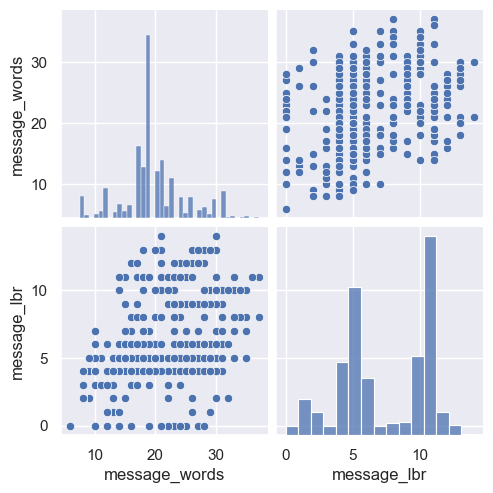

In [30]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_words', 'message_lbr']])
plt.show()

## 3. Análisis en series de tiempo

# Similarities

In [31]:
sim_work_file = f"data/{base_name}_enhanced_sim.csv"
if os.path.exists(sim_work_file):
    print(f"File {sim_work_file} already exists. Loading it.")
    df_sim = pd.read_csv(sim_work_file)
    df_sim['date_source_posted_at'] = pd.to_datetime(df_sim['date_source_posted_at'])
else:
    df_sim = df.copy()
    df_sim.rename(columns={'message_lbr': 'message_lbr_utf8'}, inplace=True)
    df_sim.rename(columns={'message_words': 'message_words_utf8'}, inplace=True)

df_sim.info()

File data/filtered_data_2_enhanced_sim.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10528 entries, 0 to 10527
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                10528 non-null  int64              
 1   source_posted_at         10528 non-null  object             
 2   message_text             10528 non-null  object             
 3   commodity                10528 non-null  object             
 4   trade_type               10517 non-null  object             
 5   telegram_user_id         7064 non-null   object             
 6   title                    10528 non-null  object             
 7   chat_id                  10528 non-null  int64              
 8   language                 10528 non-null  object             
 9   id_msg                   10528 non-null  int64              
 10  date_source_posted_at  

## additional cleanup

In [32]:
# Instalación de las bibliotecas necesarias
import os
import nltk
import spacy
import pandas as pd
import re
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [33]:
def create_word_bins(df, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                               20, 21, 22, 23, 24, 25, 26, 27, 28, 29, np.inf]):
    """
    Function to bin the word count into categories.
    You can modify 'bins' based on your use case.
    """
    # Create a new column 'word_bin' based on the number of words
    df['word_bin'] = pd.cut(df['message_words'], bins=bins, labels=False, right=False)
    return df

In [34]:

stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text, stop_words=stop_words):

    text = text.lower()
    # tokenizar el texto
    text = text.replace('\n', ' LBRMARK ')

    
    text_tokens = word_tokenize(text)
    # replace numbers with a placeholder
    # print(text_tokens)
    text_tokens_rst = text_tokens.copy() 
    i = -1
    for token in text_tokens:
        i += 1
        token = re.sub(r'\s+', ' ', token)

        # if token in stop_words:
        #     # remove the token from the list
        #     text_tokens_rst.pop(i)
        #     i -= 1
        #     # text_tokens_rst[i] = '{STOP_WORD}'
        #     continue

        if is_number(token):
            text_tokens_rst[i] = '{NUM}'
            continue

        if is_date(token):
            text_tokens_rst[i] = '{DATE}'
            continue

        tmp_token = re.sub(r'[^a-zA-Z0-9@\s]', ' ', token)  # eliminar caracteres especiales
        if tmp_token == token:
            continue
        text_tokens_rst[i] = preprocess(tmp_token)

    text = ' '.join(text_tokens_rst)
    # print(text)

    # text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)  # eliminar caracteres especiales
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # print(text)

    text = text.replace(' LBRMARK ', '\n')
    text = text.replace('LBRMARK', '\n')
    text = clean_lbr(text)
    return text


# df['tokenized_nltk'] = df['cleaned'].apply(word_tokenize)

# aclarar que se usa un dataset expandido
# Evolucion temporal con los meses con más mensajes
# conteo de users y chat_ids
# Mensajes por tipo de operación




In [35]:
force_process = False

if 'cleaned_sim' not in df_sim.columns or force_process :
    print("Cleaning messages")
    # # apply preprocess to the messages df_sim['message_text_clean_utf8']
    df_sim['cleaned_sim'] = df_sim['message_text_clean_utf8'].apply(preprocess)

    # Añadir columna con el número de palabras
    print("Checking message words")
    df_sim['message_words'] = df_sim['cleaned_sim'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df_sim['message_lbr'] = df_sim['cleaned_sim'].parallel_apply(count_line_breaks)

    print("Creating word bins")
    df_sim = create_word_bins(df_sim)

    print("Store the processed data")
    df_sim.to_csv(sim_work_file, index=False)


In [36]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10528 entries, 0 to 10527
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                10528 non-null  int64              
 1   source_posted_at         10528 non-null  object             
 2   message_text             10528 non-null  object             
 3   commodity                10528 non-null  object             
 4   trade_type               10517 non-null  object             
 5   telegram_user_id         7064 non-null   object             
 6   title                    10528 non-null  object             
 7   chat_id                  10528 non-null  int64              
 8   language                 10528 non-null  object             
 9   id_msg                   10528 non-null  int64              
 10  date_source_posted_at    10528 non-null  datetime64[ns, UTC]
 11  message_text_clean       105

## Groups to analize

Vamos a revisar los mensajes por grupos que compartan **message_lbr**, **word_bin** y **trade_type**

In [37]:
def gen_groups(df_msg):
# def gen_groups(df, group_cols):
    df_grouped = None
    print("Grouping")
    # df_grouped = df_sim.groupby([group_cols], dropna=False)
    df_grouped = df_msg.groupby(['message_lbr', 'word_bin', 'trade_type'], dropna=False)
    # transform the groupby object to a DataFrame
    df_grouped = df_grouped.size().reset_index(name='count')


    # replace NA values in commodity  wiht {Not Specified}
    df_grouped['trade_type'] = df_grouped['trade_type'].fillna('{Not Specified}')

    # sort df_grouped by count
    df_grouped = df_grouped.sort_values(by='count', ascending=False)

    return df_grouped

df_grouped = gen_groups(df_sim)

# print df_grouped size
print(f"Number of rows in df_grouped: {df_grouped.shape[0]}")

grp_min_size = 10
flt = df_grouped['count'] > grp_min_size
df_grouped2 = df_grouped[flt]

print(f"Number of rows in df_grouped filter by size > {grp_min_size}: {df_grouped2.shape[0]}")


Grouping
Number of rows in df_grouped: 230
Number of rows in df_grouped filter by size > 10: 67


In [38]:
df_grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 205 to 154
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   message_lbr  67 non-null     int64 
 1   word_bin     67 non-null     int64 
 2   trade_type   67 non-null     object
 3   count        67 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


In [39]:
df_grouped2

,message_lbr,word_bin,trade_type,count
205,16,29,buy,1464
145,8,29,buy,1332
193,12,29,buy,1158
184,11,29,buy,783
175,11,19,buy,580
...,...,...,...,...
213,20,29,buy,13
15,0,29,buy,13
159,9,29,sell,12
21,1,22,sell,12


## Compare list

Para determinar que mensajes vamos a comparar, vamos a procesarlos por una ventana de tiempo, en la que un mesaje se comparara con los otros de su grupo dentro de esa ventana. La ventana se define con el inicio del mensaje a comparar y un tamaño de ventana en días.

Por ejemplo si la ventana es de 7 días se compararia un mensaje con los que esten dentro de los siguientes 7 días a partir de la fecha del mensaje, esto dentro del grupo al que el mensaje pertenece.


In [40]:
# filter message_lbr > 0 and word_bin > 
flt = (df_grouped2['message_lbr'] > 0) 
df_grouped2 = df_grouped2[flt]

df_grouped2

,message_lbr,word_bin,trade_type,count
205,16,29,buy,1464
145,8,29,buy,1332
193,12,29,buy,1158
184,11,29,buy,783
175,11,19,buy,580
...,...,...,...,...
153,9,26,buy,13
213,20,29,buy,13
159,9,29,sell,12
21,1,22,sell,12


In [41]:
from lib.sim import *

In [42]:
# Generate a comparison list
window_size = 7
df_results = build_compare_list(df_grouped2, window_size, df_sim)

df_results

message_lbr: 16, word_bin: 29, trade_type: buy, count: 1464
message_lbr: 8, word_bin: 29, trade_type: buy, count: 1332
message_lbr: 12, word_bin: 29, trade_type: buy, count: 1158
message_lbr: 11, word_bin: 29, trade_type: buy, count: 783
message_lbr: 11, word_bin: 19, trade_type: buy, count: 580
message_lbr: 14, word_bin: 29, trade_type: buy, count: 533
message_lbr: 7, word_bin: 29, trade_type: buy, count: 495
message_lbr: 10, word_bin: 29, trade_type: buy, count: 453
###########
    lbr: 10
    word_bin: 29
    trade_type: buy
-----
{'message_lbr': 10, 'word_bin': 29, 'trade_type': 'buy', 'id_1': 12058, 'id_2': 8923, 'date_id_1': Timestamp('2022-10-14 02:11:18+0000', tz='UTC'), 'date_id_2': Timestamp('2022-10-14 05:53:52+0000', tz='UTC')}
###########
###########
    lbr: 10
    word_bin: 29
    trade_type: buy
-----
{'message_lbr': 10, 'word_bin': 29, 'trade_type': 'buy', 'id_1': 12058, 'id_2': 9471, 'date_id_1': Timestamp('2022-10-14 02:11:18+0000', tz='UTC'), 'date_id_2': Timestamp(

,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2
0,16,29,buy,9739,9488,2022-02-13 07:51:09+00:00,2022-02-18 17:37:22+00:00
1,16,29,buy,980,9488,2022-02-14 14:08:01+00:00,2022-02-18 17:37:22+00:00
2,16,29,buy,9830,9488,2022-02-14 17:56:40+00:00,2022-02-18 17:37:22+00:00
3,16,29,buy,812,9488,2022-02-14 19:10:57+00:00,2022-02-18 17:37:22+00:00
4,16,29,buy,9736,9488,2022-02-15 06:02:49+00:00,2022-02-18 17:37:22+00:00
...,...,...,...,...,...,...,...
71992,4,15,buy,408,8761,2022-01-08 21:49:21+00:00,2022-01-10 18:02:07+00:00
71993,9,26,buy,9180,4737,2022-03-01 14:36:59+00:00,2022-03-03 03:21:13+00:00
71994,9,29,sell,4454,13368,2022-04-29 09:17:45+00:00,2022-05-04 15:45:54+00:00
71995,9,29,sell,7916,13368,2022-05-02 14:38:50+00:00,2022-05-04 15:45:54+00:00


In [43]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71997 entries, 0 to 71996
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   message_lbr  71997 non-null  int64              
 1   word_bin     71997 non-null  int64              
 2   trade_type   71997 non-null  object             
 3   id_1         71997 non-null  int64              
 4   id_2         71997 non-null  int64              
 5   date_id_1    71997 non-null  datetime64[ns, UTC]
 6   date_id_2    71997 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(4), object(1)
memory usage: 3.8+ MB


In [44]:
# save the results to a file
# df_results.to_csv('data/similarity_list.csv', index=False)

In [45]:
# count the number of rows in df_results per month  
monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()
monthly_counts


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_69704/2853790557.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()


date_id_1
2022-01      576
2022-02      831
2022-03     1090
2022-04     2704
2022-05     2672
           ...  
2022-07     1598
2022-08     1949
2022-09     5041
2022-10    18227
2022-11    35584
Freq: M, Length: 11, dtype: int64

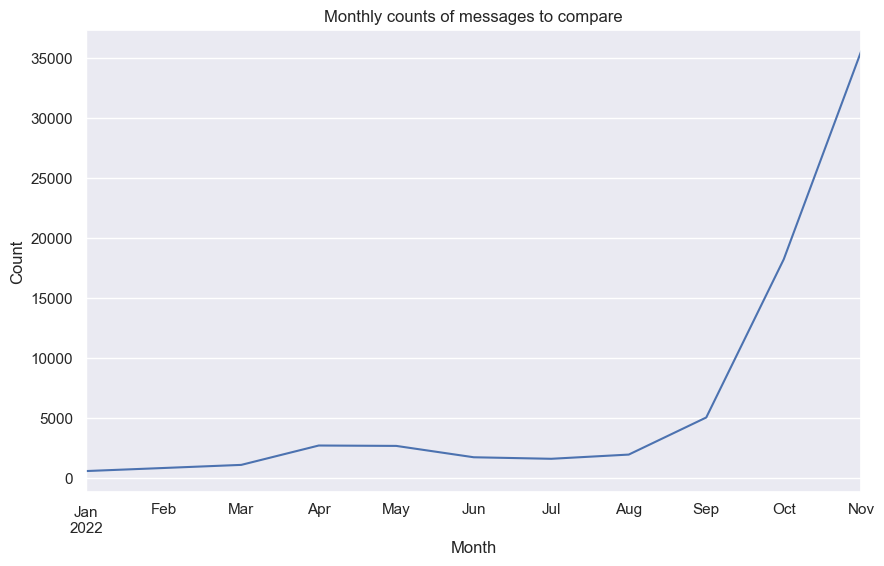

In [46]:
# plot monthly_counts
fig, ax = plt.subplots(figsize=(10, 6))
monthly_counts.plot(ax=ax)
ax.set_title('Monthly counts of messages to compare')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.show()


## Generate similarity matrix

### TFIDF approach

In [47]:
df_sim.shape

(10528, 25)

In [48]:
cols = ['id_msg', 'message_text_clean_utf8', 'cleaned_sim']
df_sim[cols].head(10)


,id_msg,message_text_clean_utf8,cleaned_sim
0,13195,#acm/btc (binance)\nbuy zone: 20194-20725\ntar...,acm btc binance\nbuy zone {NUM} {NUM}\ntarget ...
1,5851,#ada/btc (binance)\nbuy zone: 2516-2583\ntarge...,ada btc binance\nbuy zone {NUM} {NUM}\ntarget ...
2,1325,#adx/btc (binance)\nbuy zone: 835-858\ntarget ...,adx btc binance\nbuy zone {NUM} {NUM}\ntarget ...
3,1881,#agld/btc (binance)\nbuy zone: 1859-1908\ntarg...,agld btc binance\nbuy zone {NUM} {NUM}\ntarget...
4,6316,#agld/btc (binance)\nbuy zone: 1950-2001\ntarg...,agld btc binance\nbuy zone {NUM} {NUM}\ntarget...
5,9163,#alpine/btc (binance)\nbuy zone: 14833-15224\n...,alpine btc binance\nbuy zone {NUM} {NUM}\ntarg...
6,4125,#amb/btc (binance)\nbuy zone: 82-85\ntarget 1:...,amb btc binance\nbuy zone {NUM} {NUM}\ntarget ...
7,1897,#amp/btc (binance)\nbuy zone: 40-41\ntarget 1:...,amp btc binance\nbuy zone {NUM} {NUM}\ntarget ...
8,3145,#anc/btc (binance)\nbuy zone: 573-588\ntarget ...,anc btc binance\nbuy zone {NUM} {NUM}\ntarget ...
9,5959,#ankr/btc (binance)\nbuy zone: 193-198\ntarget...,ankr btc binance\nbuy zone {NUM} {NUM}\ntarget...


In [49]:
#filter df_results for jan, feb and mar
# flt = df_results['date_id_1'].dt.month.isin([1, 2, 3])
# flt = df_results['date_id_1'].dt.month.isin([6])
# df_results_jan_mar = df_results[flt]
# df_results_jan_mar = df_results_jan_mar.head(10000)
# df_results_jan_mar.shape

In [50]:
tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['message_text_clean_utf8'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])


In [51]:


# Add the similarities to df_comp
# df_comp['similarity'] = similarities2

# Measure end time

# Output the df_comp with similarities
# print(df_comp)

# # Print total number of rows, percentage, and performance stats
# print(f"Number of rows in df_comp: {df_comp.shape[0]}")
# print(f"Number of rows in df_results: {df_results.shape[0]}")
# print(f"Percentage of df_comp: {df_comp.shape[0]/df_results.shape[0]:.2%}")
# print(f"Time taken: {elapsed:.2f} seconds")
# print(f"Number of rows per second: {df_comp.shape[0]/elapsed:.2f}")

# # Extrapolate the time to run the code for the entire df_results
# estimated_time = df_results.shape[0] / df_comp.shape[0] * elapsed
# print(f"Estimated time for the entire df_results: {estimated_time:.2f} seconds")


In [52]:

df_comp_src = df_results
df_comp_src['similarity'] = get_similarities(df_comp_src, tfidf_matrix, df_sim)

In [53]:
# # filter df_comp_sorted by similarity < 0.9
# df_comp_sorted = df_comp.sort_values(by='similarity', ascending=False)
# flt = ( df_comp['distance'] < 0.4 ) & (df_comp['distance'] > 0.2)
# df_comp_sorted[flt]


In [54]:
# df_comp.head(10)
df_comp_src = enrich_similarities(df_comp_src, df_sim)
df_comp_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71997 entries, 0 to 71996
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                71997 non-null  int64              
 1   word_bin                   71997 non-null  int64              
 2   trade_type                 71997 non-null  object             
 3   id_1                       71997 non-null  int64              
 4   id_2                       71997 non-null  int64              
 5   similarity                 71997 non-null  float64            
 6   message_text_clean_utf8_1  71997 non-null  object             
 7   cleaned_sim_1              71997 non-null  object             
 8   chat_id_1                  71997 non-null  int64              
 9   date_id_1                  71997 non-null  datetime64[ns, UTC]
 10  message_text_clean_utf8_2  71997 non-null  object             
 11  cl

In [55]:
# filter df_comp by similarity > 0.8
# flt = df_comp_src['similarity'] == 1
flt = df_comp_src['similarity'] > 0.8
df_comp = df_comp_src[flt]


In [122]:
df_comp

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
5102,8,29,buy,12187,10737,0.893146,#kmd/usdt (binance)\nbuy zone: 0.4234-0.4346\n...,kmd usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,3,2022-05-09 10:53:20+00:00,#beta/usdt (binance)\nbuy zone: 0.1135-0.1165\...,beta usdt binance\nbuy zone {NUM} {NUM} {NUM} ...,67,2022-05-15 10:05:13+00:00,0.10685
5103,8,29,buy,12187,9618,0.884671,#kmd/usdt (binance)\nbuy zone: 0.4234-0.4346\n...,kmd usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,3,2022-05-09 10:53:20+00:00,#uma/usdt (binance)\nbuy zone: 3.1288-3.2112\n...,uma usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,67,2022-05-15 10:20:07+00:00,0.11533
5104,8,29,buy,12187,5171,0.884671,#kmd/usdt (binance)\nbuy zone: 0.4234-0.4346\n...,kmd usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,3,2022-05-09 10:53:20+00:00,#dego/usdt (binance)\nbuy zone: 1.3522-1.3878\...,dego usdt binance\nbuy zone {NUM} {NUM} {NUM} ...,67,2022-05-15 10:40:17+00:00,0.11533
5105,8,29,buy,12187,7334,0.870327,#kmd/usdt (binance)\nbuy zone: 0.4234-0.4346\n...,kmd usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,3,2022-05-09 10:53:20+00:00,#burger/usdt (binance)\nbuy zone: 0.4718-0.484...,burger usdt binance\nbuy zone {NUM} {NUM} {NUM...,67,2022-05-15 10:53:24+00:00,0.12967
5106,8,29,buy,12187,1291,0.892108,#kmd/usdt (binance)\nbuy zone: 0.4234-0.4346\n...,kmd usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,3,2022-05-09 10:53:20+00:00,#aca/usdt (binance)\nbuy zone: 0.5458-0.5602\n...,aca usdt binance\nbuy zone {NUM} {NUM} {NUM} {...,67,2022-05-15 11:15:16+00:00,0.10789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71984,1,22,buy,1799,2070,0.819359,ocr:\n#hive (binance) buy zone 2600-2790 sell ...,ocr\nhive binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-11 04:32:06+00:00,ocr:\n#pond (binance) buy zone 54-58 sell zone...,ocr\npond binance buy zone {NUM} {NUM} sell zo...,1735,2022-10-15 09:34:56+00:00,0.18064
71985,1,22,buy,1799,2505,0.807873,ocr:\n#hive (binance) buy zone 2600-2790 sell ...,ocr\nhive binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-11 04:32:06+00:00,ocr:\n#lto (binance) buy zone 400-435 sell zon...,ocr\nlto binance buy zone {NUM} {NUM} sell zon...,1735,2022-10-15 16:23:38+00:00,0.19213
71986,1,22,buy,1799,2491,0.811477,ocr:\n#hive (binance) buy zone 2600-2790 sell ...,ocr\nhive binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-11 04:32:06+00:00,ocr:\n#ctxc (binance) buy zone 568-617 sell zo...,ocr\nctxc binance buy zone {NUM} {NUM} sell zo...,1735,2022-10-16 05:10:42+00:00,0.18852
71987,1,22,buy,1799,2502,0.814496,ocr:\n#hive (binance) buy zone 2600-2790 sell ...,ocr\nhive binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-11 04:32:06+00:00,ocr:\n#idex (binance) buy zone 307-334 sell zo...,ocr\nidex binance buy zone {NUM} {NUM} sell zo...,1735,2022-10-16 17:56:01+00:00,0.18550


In [56]:
df_comp_src = df_comp_src.sort_values(by='similarity', ascending=False)
flt_sim = (df_comp_src['similarity'] < 1) & (df_comp_src['similarity'] > 0.8)
df_comp_flt = df_comp_src[flt_sim]

# loop over df_comp_src and print the messages
for idx, row in df_comp_flt.head(10).iterrows():
    print(f"similarity: {row['similarity']}")
    print(f"chat_id_1: {row['chat_id_1']}")
    print(f"chat_id_2: {row['chat_id_2']}")

    print(f"date_id_1: {row['date_id_1']}")
    print(f"date_id_2: {row['date_id_2']}")
    print("-" * 50*2)
    print_side_by_side(row['message_text_clean_utf8_1'], row['message_text_clean_utf8_2'], width=50, linebreak_symbol='↵')
    print("=" * 50*2)
    print_side_by_side(row['cleaned_sim_1'], row['cleaned_sim_2'], width=50, linebreak_symbol='↵')

    print("_" * 50*2)

similarity: 0.9999999999999999
chat_id_1: 1751
chat_id_2: 1735
date_id_1: 2022-10-13 04:57:14+00:00
date_id_2: 2022-10-13 04:57:31+00:00
----------------------------------------------------------------------------------------------------
ocr:↵                                              | ocr:↵                                             
#qkc (binance) buy zone 51-55 sell zone            | #qkc (binance) buy zone 51-55 sell zone           
57-62-66-73+ by @crypto_pump_island (@apglobals)   | 57-62-66-73+ by @crypto_pump_island (@apglobals)  
ocr↵                                               | ocr↵                                              
qkc binance buy zone {NUM} {NUM} sell zone {NUM}   | qkc binance buy zone {NUM} {NUM} sell zone {NUM}  
{NUM} {NUM} {NUM} by @ crypto pump island @        | {NUM} {NUM} {NUM} by @ crypto pump island @       
apglobals                                          | apglobals                                         
__________________________________

## Clustering messages

### Clusters por grupos de mensajes

In [57]:

# clusters_agglomerative = gen_cluster(df_comp, 'AgglomerativeClustering')
# df_grouped['agglomerative'] = clusters_agglomerative

clusters_affinity_propagation = gen_cluster(df_comp, 'AffinityPropagation')


# flt_small = (df_comp['message_lbr'] == 12) & (df_comp['word_bin'] == 29) & (df_comp['trade_type'] == 'buy')
# df_comp_test = df_comp[flt_small]
# # clusters_affinity_propagation = gen_cluster(df_comp_test, 'AffinityPropagation')

# clusters_affinity_propagation = gen_cluster(df_comp_test, 'AffinityPropagation')
# clusters_agglomerative = gen_cluster(df_comp_test, 'AgglomerativeClustering')


message_lbr: 1, word_bin: 20, trade_type: buy, count: 43
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 1, word_bin: 22, trade_type: buy, count: 17
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 1, word_bin: 29, trade_type: buy, count: 355
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 2, word_bin: 13, trade_type: buy, count: 1
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 3, word_bin: 19, trade_type: buy, count: 9
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 14, trade_type: buy, count: 12
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 18, trade_type: buy, count: 2
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 21, trade_type: buy, count: 9
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 5, word_bin: 18, trade_type: buy, count: 5
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 5, word_bin: 19, trade_type: buy, count: 8
Ids

/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:52: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:52: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:52: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 11, word_bin: 29, trade_type: buy, count: 118
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 12, word_bin: 29, trade_type: buy, count: 18840
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 12, word_bin: 29, trade_type: sell, count: 1
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 13, word_bin: 29, trade_type: buy, count: 2
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 13, word_bin: 29, trade_type: sell, count: 1
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 14, word_bin: 29, trade_type: buy, count: 32
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 15, word_bin: 29, trade_type: sell, count: 2
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 16, word_bin: 29, trade_type: sell, count: 12
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 17, word_bin: 29, trade_type: sell, count: 86
Ids in ids_check not in df_comp: {11921, 

/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:52: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:52: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


In [58]:
clusters_affinity_propagation                                                                       

[[[2562, 2585, 1797, 2557, 2551, 1725, 1717],
  [1743, 2596, 2594, 1720, 2592, 1737, 2091, 1883, 2546],
  [1714, 2601]],
 [[2606, 1678, 1814, 1811, 2598], [2581, 2070, 2505, 2491, 2502, 1799]],
 [[2607,
   2593,
   2590,
   2586,
   1635,
   1712,
   1713,
   1722,
   2595,
   2591,
   2589,
   2603,
   1675,
   1711,
   1679,
   1673,
   2332,
   1827,
   2500,
   1681,
   1680,
   2212,
   1882,
   1672,
   2075,
   2499,
   1726,
   2221],
  [1813,
   1676,
   1810,
   1804,
   2675,
   1803,
   2541,
   1729,
   1728,
   1801,
   2597,
   1800,
   2558,
   1724,
   1723,
   10165,
   2543]],
 [[13767, 13849]],
 [[1516, 1825, 11146],
  [1470, 1826],
  [9548, 7292],
  [5494, 3391],
  [9603, 3282],
  [5275, 1815, 3335]],
 [[13852, 13814, 13830], [13764, 13829, 13877]],
 [[4445, 32, 4480]],
 [[9786, 8988], [5557, 1816, 1768, 1934, 1592]],
 [[58, 5957, 837, 1088, 4507, 2024]],
 [[1073, 4415, 4414],
  [3884, 11210],
  [722, 8367],
  [6740, 7016, 6881],
  [4066, 11164],
  [7132, 1508]],
 

In [59]:
# count the number of clusters in clusters_affinity_propagation
total = 0
for idx, cluster in enumerate(clusters_affinity_propagation):
    clusters_in_grp = len(cluster)
    print(f"grp {idx}: {clusters_in_grp}")
    total += clusters_in_grp
print(f"Total number of clusters: {total}")

grp 0: 3
grp 1: 2
grp 2: 2
grp 3: 1
grp 4: 6
grp 5: 2
grp 6: 1
grp 7: 2
grp 8: 1
grp 9: 6
grp 10: 1
grp 11: 1
grp 12: 15
grp 13: 3
grp 14: 1
grp 15: 1
grp 16: 1
grp 17: 7
grp 18: 6
grp 19: 13
grp 20: 1
grp 21: 1
grp 22: 1
grp 23: 2
grp 24: 1
grp 25: 2
grp 26: 5
grp 27: 1
Total number of clusters: 89


In [60]:
from itertools import chain
# ids = set(list(chain.from_iterable(clusters_affinity_propagation[0])))

ids = clusters_affinity_propagation[1][0]
# ids = [11921, 10405, 4042]
ids = [3422, 3556, 13634, 7908, 6496, 6533, 5939, 3415, 11125, 6453, 5823, 12527, 6187, 6539, 6455, 3405, 5908, 3825, 7513, 11664, 11400, 3945, 9474, 3930, 6470]

print(ids)

# filter df_comp by message_lbr: 1, word_bin: 14, trade_type: buy, count: 357
flt = df_comp['id_1'].isin(ids) & df_comp['id_2'].isin(ids)
df_comp_flt = df_comp[flt]
df_comp_flt

[3422, 3556, 13634, 7908, 6496, 6533, 5939, 3415, 11125, 6453, 5823, 12527, 6187, 6539, 6455, 3405, 5908, 3825, 7513, 11664, 11400, 3945, 9474, 3930, 6470]


,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
26454,12,29,buy,3945,3556,0.809684,#chz/usdt\n#short\nleverage : 10x - 20x\nentr...,chz usdt\nshort\nleverage 10x 20x\nentry {NUM}...,191,2022-10-25 04:21:52+00:00,maskusdt\nshort\nentry: 2.193-2.25879\nleverag...,maskusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-30 15:10:15+00:00,0.19032
26983,12,29,buy,3930,3556,0.802681,#yfi/usdt\n#short\nleverage : 10x - 20x\nentr...,yfi usdt\nshort\nleverage 10x 20x\nentry {NUM}...,191,2022-10-25 16:32:43+00:00,maskusdt\nshort\nentry: 2.193-2.25879\nleverag...,maskusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-30 15:10:15+00:00,0.19732
27192,12,29,buy,11664,3556,0.812311,#xrp/usdt\n#short\nleverage : 10x - 20x\nentr...,xrp usdt\nshort\nleverage 10x 20x\nentry {NUM}...,191,2022-10-26 04:34:39+00:00,maskusdt\nshort\nentry: 2.193-2.25879\nleverag...,maskusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-30 15:10:15+00:00,0.18769
27200,12,29,buy,11664,3422,0.800570,#xrp/usdt\n#short\nleverage : 10x - 20x\nentr...,xrp usdt\nshort\nleverage 10x 20x\nentry {NUM}...,191,2022-10-26 04:34:39+00:00,chzusdt\nlong\nentry: 0.2214-0.214758\nleverag...,chzusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\n...,114,2022-10-31 06:10:08+00:00,0.19943
27448,12,29,buy,7513,3556,0.812503,#matic/usdt\n#short\nleverage : 10x - 20x\nen...,matic usdt\nshort\nleverage 10x 20x\nentry {NU...,191,2022-10-27 04:02:12+00:00,maskusdt\nshort\nentry: 2.193-2.25879\nleverag...,maskusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-30 15:10:15+00:00,0.18750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29763,12,29,buy,6187,13634,0.880294,ccf\npair : ethusdt\nshort\nleverage : cross 2...,ccf\npair ethusdt\nshort\nleverage cross 20x\n...,101,2022-11-02 20:45:01+00:00,long\n#ontusdt\nleverage : cross 20x\nentry : ...,long\nontusdt\nleverage cross 20x\nentry {NUM}...,187,2022-11-04 13:03:36+00:00,0.11971
29783,12,29,buy,5908,13634,0.872525,ccf\npair : iotausdt\nshort\nleverage : cross ...,ccf\npair iotausdt\nshort\nleverage cross 20x\...,101,2022-11-02 21:46:00+00:00,long\n#ontusdt\nleverage : cross 20x\nentry : ...,long\nontusdt\nleverage cross 20x\nentry {NUM}...,187,2022-11-04 13:03:36+00:00,0.12747
30453,12,29,buy,13634,5939,0.884569,long\n#ontusdt\nleverage : cross 20x\nentry : ...,long\nontusdt\nleverage cross 20x\nentry {NUM}...,187,2022-11-04 13:03:36+00:00,ccf\npair : maskusdt\nlong\nleverage : cross 2...,ccf\npair maskusdt\nlong\nleverage cross 20x\n...,101,2022-11-04 23:30:07+00:00,0.11543
30457,12,29,buy,13634,7908,0.884569,long\n#ontusdt\nleverage : cross 20x\nentry : ...,long\nontusdt\nleverage cross 20x\nentry {NUM}...,187,2022-11-04 13:03:36+00:00,ccf\npair : maskusdt\nlong\nleverage : cross 2...,ccf\npair maskusdt\nlong\nleverage cross 20x\n...,101,2022-11-05 19:00:09+00:00,0.11543


In [61]:
cols = ['id_msg', 'message_lbr_utf8', 'message_lbr', 'word_bin', 'message_words_utf8', 'message_words', 'message_text_clean_utf8', 'cleaned_sim']
# df_sim[cols].sample(5)
# filter by id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
# [1678, 2606, 1814, 1811, 2598, 1797, 1799]
flt = df_sim['id_msg'].isin(ids)
df_sim[cols][flt]

,id_msg,message_lbr_utf8,message_lbr,word_bin,message_words_utf8,message_words,message_text_clean_utf8,cleaned_sim
5221,6453,12,12,29,46,34,ccf\npair : btcusdt\nshort\nleverage : cross 2...,ccf\npair btcusdt\nshort\nleverage cross 20x\n...
5222,5823,12,12,29,46,34,ccf\npair : btcusdt\nshort\nleverage : cross 2...,ccf\npair btcusdt\nshort\nleverage cross 20x\n...
5316,6187,12,12,29,46,34,ccf\npair : ethusdt\nshort\nleverage : cross 2...,ccf\npair ethusdt\nshort\nleverage cross 20x\n...
5317,12527,12,12,29,46,34,ccf\npair : ethusdt\nshort\nleverage : cross 2...,ccf\npair ethusdt\nshort\nleverage cross 20x\n...
5447,5908,12,12,29,46,34,ccf\npair : iotausdt\nshort\nleverage : cross ...,ccf\npair iotausdt\nshort\nleverage cross 20x\...
...,...,...,...,...,...,...,...,...
7990,3825,12,12,29,37,33,#doge/usdt\n#short\nleverage : 10x - 20x\nent...,doge usdt\nshort\nleverage 10x 20x\nentry {NUM...
7991,11400,12,12,29,37,33,#dot/usdt\n#short\nleverage : 10x - 20x\nentr...,dot usdt\nshort\nleverage 10x 20x\nentry {NUM}...
8001,7513,12,12,29,37,33,#matic/usdt\n#short\nleverage : 10x - 20x\nen...,matic usdt\nshort\nleverage 10x 20x\nentry {NU...
8012,11664,12,12,29,37,33,#xrp/usdt\n#short\nleverage : 10x - 20x\nentr...,xrp usdt\nshort\nleverage 10x 20x\nentry {NUM}...


In [62]:
grp_ids_cluster = [ids]
cfg = {
    "Cosine": df_comp,
}
# check_sim(grp_ids_cluster, cfg, df_sim, ['cleaned_sim', 'message_text_clean_utf8'])
check_sim(grp_ids_cluster, cfg, df_sim, ['cleaned_sim'])

------
Grupo: [3422, 3556, 13634, 7908, 6496, 6533, 5939, 3415, 11125, 6453, 5823, 12527, 6187, 6539, 6455, 3405, 5908, 3825, 7513, 11664, 11400, 3945, 9474, 3930, 6470]
 --- msg_id: 3405 ---
12 - 29 - buy
 ----------
     ------
ccf
pair iotausdt
short
leverage cross 20x
entry {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}
 --- msg_id: 3415 ---
12 - 29 - buy
 ----------
     ------
ccf
pair maskusdt
long
leverage cross 20x
entry {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}
 --- msg_id: 3422 ---
12 - 29 - buy
 ----------
     ------
chzusdt
long
entry {NUM} {NUM} {NUM} {NUM}
leverage cross 25x
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}
 

In [63]:
from itertools import chain


def gen_clusters_groups_df(clusters_groups):
    compare_list = []
    cluster_grp_id = -1
    cluster_count = 0
    print(f'Total number of groups: {len(clusters_groups)}')
    for cluster_grp in clusters_groups:
        cluster_grp_id += 1
        print(f'Total number of cluster in group {cluster_grp_id}: {len(cluster_grp)}')
        cluster_id = -1
        for cluster in cluster_grp:
            cluster_id += 1
            cluster_count += 1
            # combine the lists by pairs with no repetitions
            combs = set([frozenset([id1, id2]) for id2 in cluster for id1 in cluster if id1 != id2])
            # print(combs)
            for pair in combs:
                lpair = list(pair)
                compare_list.append({
                    'c_id': f'{cluster_grp_id}-{cluster_id}',
                    'c_grp': cluster_grp_id,
                    'sc_id': cluster_id,
                    'id_1': lpair[0], 'id_2': lpair[1]})
                # print(pair)
                # print(pair[0], pair[1])

        # generate a dataframe from compare_list
    clusters_compare_df = pd.DataFrame.from_dict(compare_list)
    print(f'Total number of clusters: {cluster_count}')
    return clusters_compare_df

In [64]:
clusters_compare_df = gen_clusters_groups_df(clusters_affinity_propagation)

# clusters_compare_df = gen_clusters_groups_df(clusters_agglomerative)


Total number of groups: 28
Total number of cluster in group 0: 3
Total number of cluster in group 1: 2
Total number of cluster in group 2: 2
Total number of cluster in group 3: 1
Total number of cluster in group 4: 6
Total number of cluster in group 5: 2
Total number of cluster in group 6: 1
Total number of cluster in group 7: 2
Total number of cluster in group 8: 1
Total number of cluster in group 9: 6
Total number of cluster in group 10: 1
Total number of cluster in group 11: 1
Total number of cluster in group 12: 15
Total number of cluster in group 13: 3
Total number of cluster in group 14: 1
Total number of cluster in group 15: 1
Total number of cluster in group 16: 1
Total number of cluster in group 17: 7
Total number of cluster in group 18: 6
Total number of cluster in group 19: 13
Total number of cluster in group 20: 1
Total number of cluster in group 21: 1
Total number of cluster in group 22: 1
Total number of cluster in group 23: 2
Total number of cluster in group 24: 1
Total 

In [65]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93993 entries, 0 to 93992
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c_id    93993 non-null  object
 1   c_grp   93993 non-null  int64 
 2   sc_id   93993 non-null  int64 
 3   id_1    93993 non-null  int64 
 4   id_2    93993 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.6+ MB


In [66]:
clusters_similarities =  get_similarities(clusters_compare_df, tfidf_matrix, df_sim)

In [67]:
clusters_compare_df['similarity'] = clusters_similarities

# enrich the similarities
clusters_compare_df = enrich_similarities(clusters_compare_df, df_sim)




In [68]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93993 entries, 0 to 93992
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   c_id                       93993 non-null  object             
 1   c_grp                      93993 non-null  int64              
 2   sc_id                      93993 non-null  int64              
 3   id_1                       93993 non-null  int64              
 4   id_2                       93993 non-null  int64              
 5   similarity                 93993 non-null  float64            
 6   message_text_clean_utf8_1  93993 non-null  object             
 7   cleaned_sim_1              93993 non-null  object             
 8   chat_id_1                  93993 non-null  int64              
 9   date_id_1                  93993 non-null  datetime64[ns, UTC]
 10  message_text_clean_utf8_2  93993 non-null  object             
 11  cl

In [69]:
clusters_compare_df

,c_id,c_grp,sc_id,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
0,0-0,0,0,1725,2551,0.800554,ocr:\n#agix (binance) buy zone 362-393 sell zo...,ocr\nagix binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-13 06:28:18+00:00,ocr:\n#ast (binance) buy zone 634-688 sell zon...,ocr\nast binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-13 05:02:22+00:00,0.19945
1,0-0,0,0,2562,1725,0.800554,ocr:\n#ast (binance) buy zone 540-575 sell zon...,ocr\nast binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-06 09:20:57+00:00,ocr:\n#agix (binance) buy zone 362-393 sell zo...,ocr\nagix binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-13 06:28:18+00:00,0.19945
2,0-0,0,0,1797,1717,0.805529,ocr:\n#mdx (binance) buy zone 413-440 sell zon...,ocr\nmdx binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-10 19:42:42+00:00,ocr:\n#wabi (binance) buy zone 497-548 sell zo...,ocr\nwabi binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-13 08:14:20+00:00,0.19447
3,0-0,0,0,2562,2557,0.793439,ocr:\n#ast (binance) buy zone 540-575 sell zon...,ocr\nast binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-06 09:20:57+00:00,ocr:\n#qkc (binance) buy zone 51-55 sell zone ...,ocr\nqkc binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-13 04:57:14+00:00,0.20656
4,0-0,0,0,2585,1797,1.000000,ocr:\n#mdx (binance) buy zone 413-440 sell zon...,ocr\nmdx binance buy zone {NUM} {NUM} sell zon...,1735,2022-10-10 19:42:58+00:00,ocr:\n#mdx (binance) buy zone 413-440 sell zon...,ocr\nmdx binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-10 19:42:42+00:00,-0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93988,27-0,27,0,613,9535,0.910880,"#sushi/usdt\nexchanges: binance futures, bybit...",sushi usdt\nexchanges binance futures bybit us...,2269,2022-05-01 00:28:38+00:00,"#bnb/usdt\nexchanges: binance futures, bybit u...",bnb usdt\nexchanges binance futures bybit usdt...,2269,2022-04-30 23:49:29+00:00,0.08912
93989,27-0,27,0,9538,9535,0.927666,"#ltc/usdt\nexchanges: binance futures, bybit u...",ltc usdt\nexchanges binance futures bybit usdt...,2269,2022-05-06 07:52:06+00:00,"#bnb/usdt\nexchanges: binance futures, bybit u...",bnb usdt\nexchanges binance futures bybit usdt...,2269,2022-04-30 23:49:29+00:00,0.07233
93990,27-0,27,0,9538,605,0.937743,"#ltc/usdt\nexchanges: binance futures, bybit u...",ltc usdt\nexchanges binance futures bybit usdt...,2269,2022-05-06 07:52:06+00:00,"#axs/usdt\nexchanges: binance futures, bybit u...",axs usdt\nexchanges binance futures bybit usdt...,2269,2022-04-30 23:44:09+00:00,0.06226
93991,27-0,27,0,10049,551,0.865020,"signal\n#enj/usdt\nexchanges: bybit usdt, bina...",signal\nenj usdt\nexchanges bybit usdt binance...,2172,2022-05-05 13:39:57+00:00,"#btc/usdt\nexchanges: binance futures, bybit u...",btc usdt\nexchanges binance futures bybit usdt...,2269,2022-05-02 18:38:41+00:00,0.13498


In [70]:
# Filter pairs form the same chat_id
flt = clusters_compare_df['chat_id_1'] != clusters_compare_df['chat_id_2']
clusters_compare_df = clusters_compare_df[flt]
# print number of rows in clusters_compare_df
print(f"Number of rows in clusters_compare_df: {clusters_compare_df.shape[0]}")

Number of rows in clusters_compare_df: 8980


In [71]:
# add a column chats-idx with joining chat_id_1 and chat_id_2 with a - in a sorted order
clusters_compare_df.loc[:, 'chats-idx'] = clusters_compare_df.apply(lambda x: '-'.join(sorted([str(x['chat_id_1']), str(x['chat_id_2'])])), axis=1)

# count the number of distinct chats-idx per each c_id and filter the c_id with more than 1 distint chats-idx
flt = (clusters_compare_df.groupby('c_id')['chats-idx'].nunique() > 1)
# flt = (clusters_compare_df.groupby('c_id')['chats-idx'].nunique() > 1) & (clusters_compare_df.groupby('c_id')['chats-idx'].nunique() < 10)
sub_grp = clusters_compare_df.groupby('c_id')['chats-idx'].nunique()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
clusters_compare_df = clusters_compare_df[flt]

# filter clusters_compare_df by similarity > 0.8
flt = clusters_compare_df['similarity'] > 0.8
clusters_compare_df = clusters_compare_df[flt]

# print the number of rows in clusters_compare_df
print(f"Number of rows in clusters_compare_df: {clusters_compare_df.shape[0]}")


Number of rows in clusters_compare_df: 8236


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_69704/3759648473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_compare_df.loc[:, 'chats-idx'] = clusters_compare_df.apply(lambda x: '-'.join(sorted([str(x['chat_id_1']), str(x['chat_id_2'])])), axis=1)


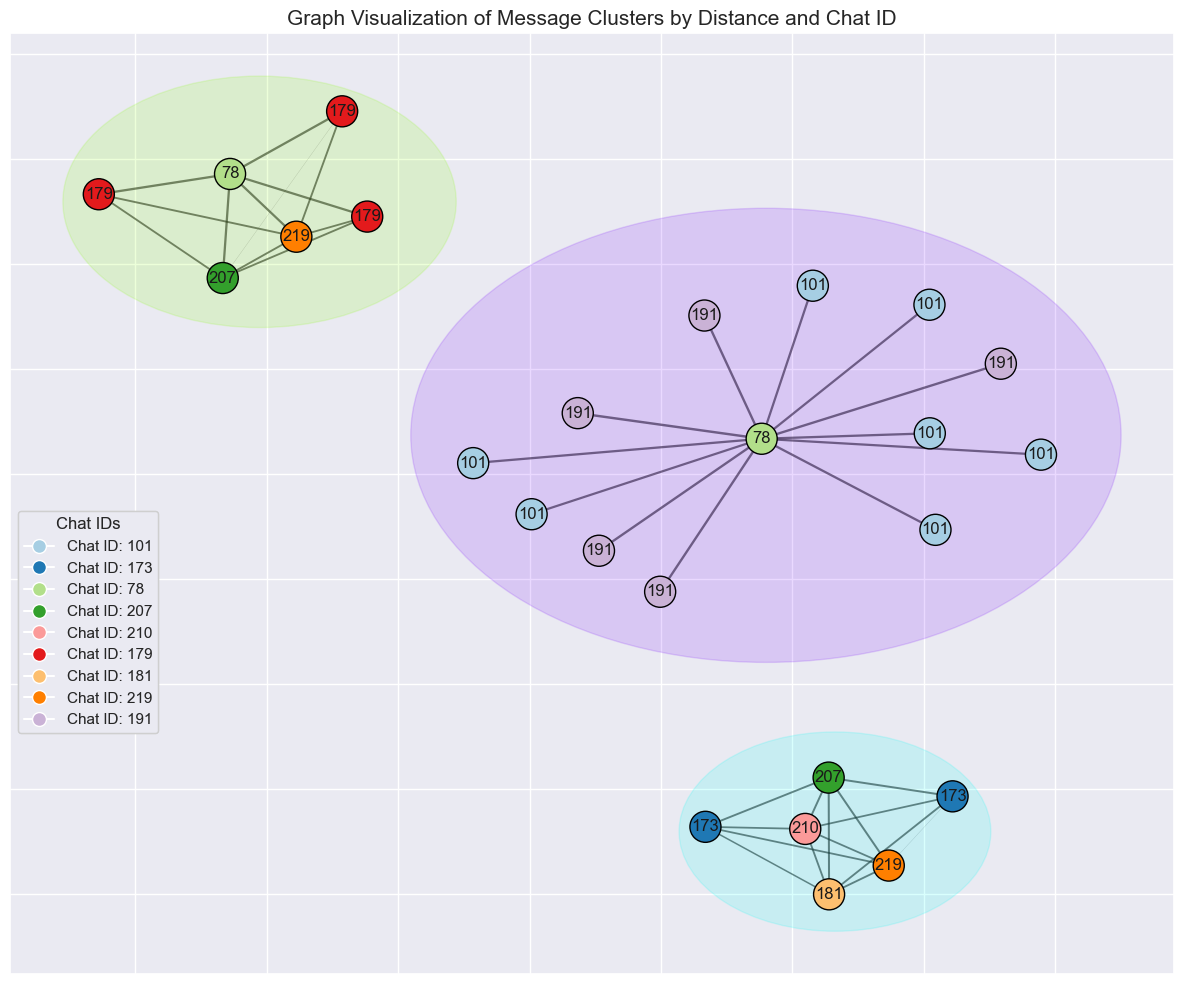

In [72]:
# count values of c_id
clusters_compare_df['c_id'].value_counts()
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 10) & (clusters_compare_df['c_id'].value_counts() < 20)
# flt =  (clusters_compare_df['c_id'].value_counts() < 3)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]
plot_clusters(test_clusters, 0.6)

In [73]:
check_sim_clusters(test_clusters, [0,1])

 --- 19-8 ---
Similarity: 0.8365885793013519
_____________________________________________________________________________________________________
Chat ID: 101                                       | Chat ID: 78                                       
ccf↵                                               | coin : #ftt/usdt↵                                 
pair : lptusdt↵                                    | short↵                                            
long↵                                              | entry: 3.970 - 6.20↵                              
leverage : cross 20x↵                              | stoploss : 6.40↵                                  
entry : 10.01 - 9.7097↵                            | target 1: 3.90↵                                   
target 1 : 10.06505↵                               | target 2: 3.82↵                                   
target 2 : 10.14012↵                               | target 3: 3.60↵                                   
target 3 : 10.26024↵ 

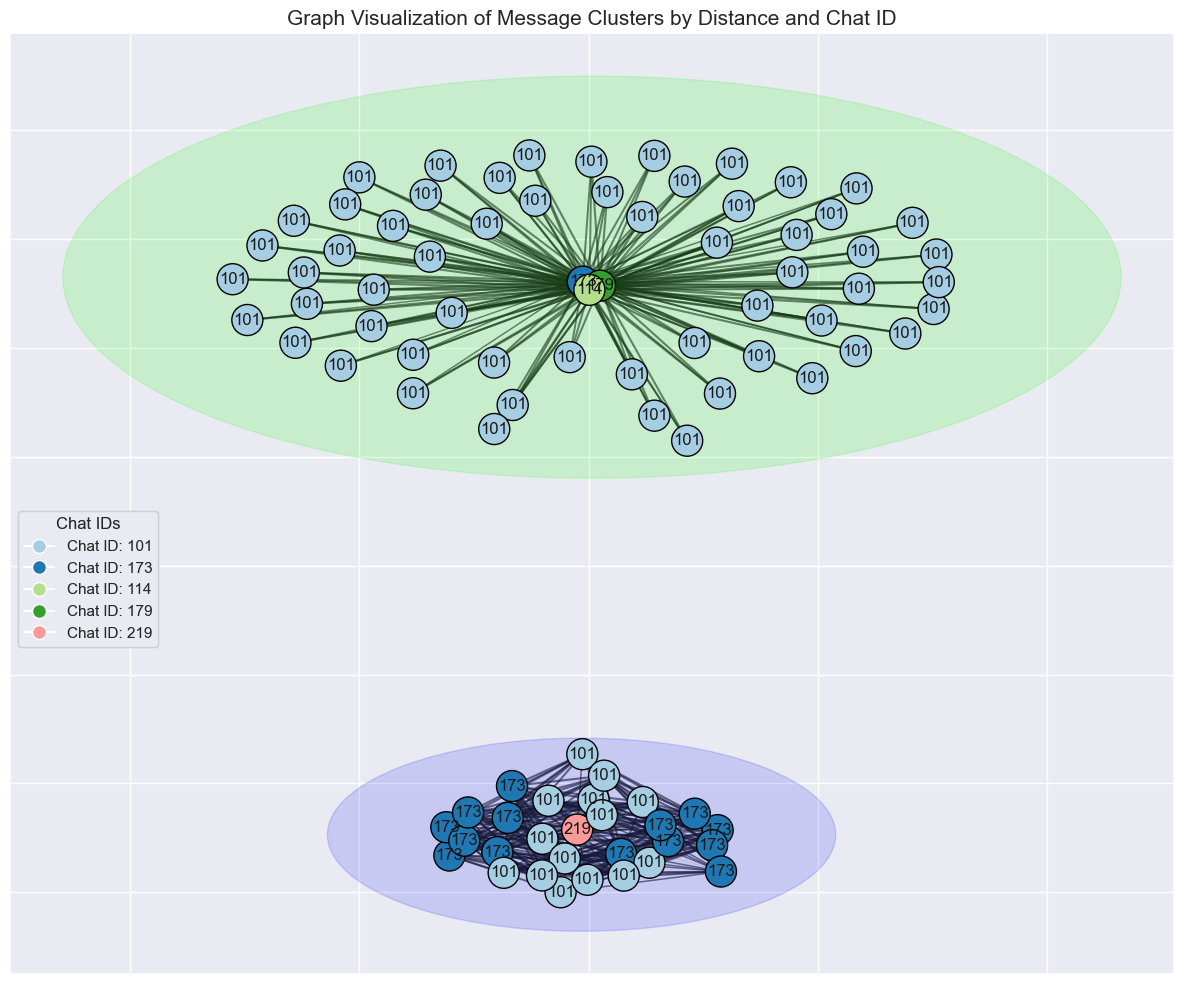

2

In [74]:
# count values of c_id
clusters_compare_df['c_id'].value_counts()
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 100) & (clusters_compare_df['c_id'].value_counts() < 250)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]
plot_clusters(test_clusters, 0.3)

# count the number of clusters intest_clusters
test_clusters['c_id'].nunique()


In [75]:
check_sim_clusters(test_clusters, [0,1])

 --- 19-10 ---
Similarity: 0.8962409044757781
_____________________________________________________________________________________________________
Chat ID: 101                                       | Chat ID: 173                                      
ccf↵                                               | maskusdt↵                                         
pair : galausdt↵                                   | short↵                                            
short↵                                             | entry: 2.883-2.96949↵                             
leverage : cross 20x↵                              | leverage: cross 25x↵                              
entry : 0.02726 - 0.02824↵                         | target 1 - 2.868585↵                              
target 1 : 0.02712↵                                | target 2 - 2.839755↵                              
target 2 : 0.02668↵                                | target 3 - 2.810925↵                              
target 3 : 0.02636↵ 

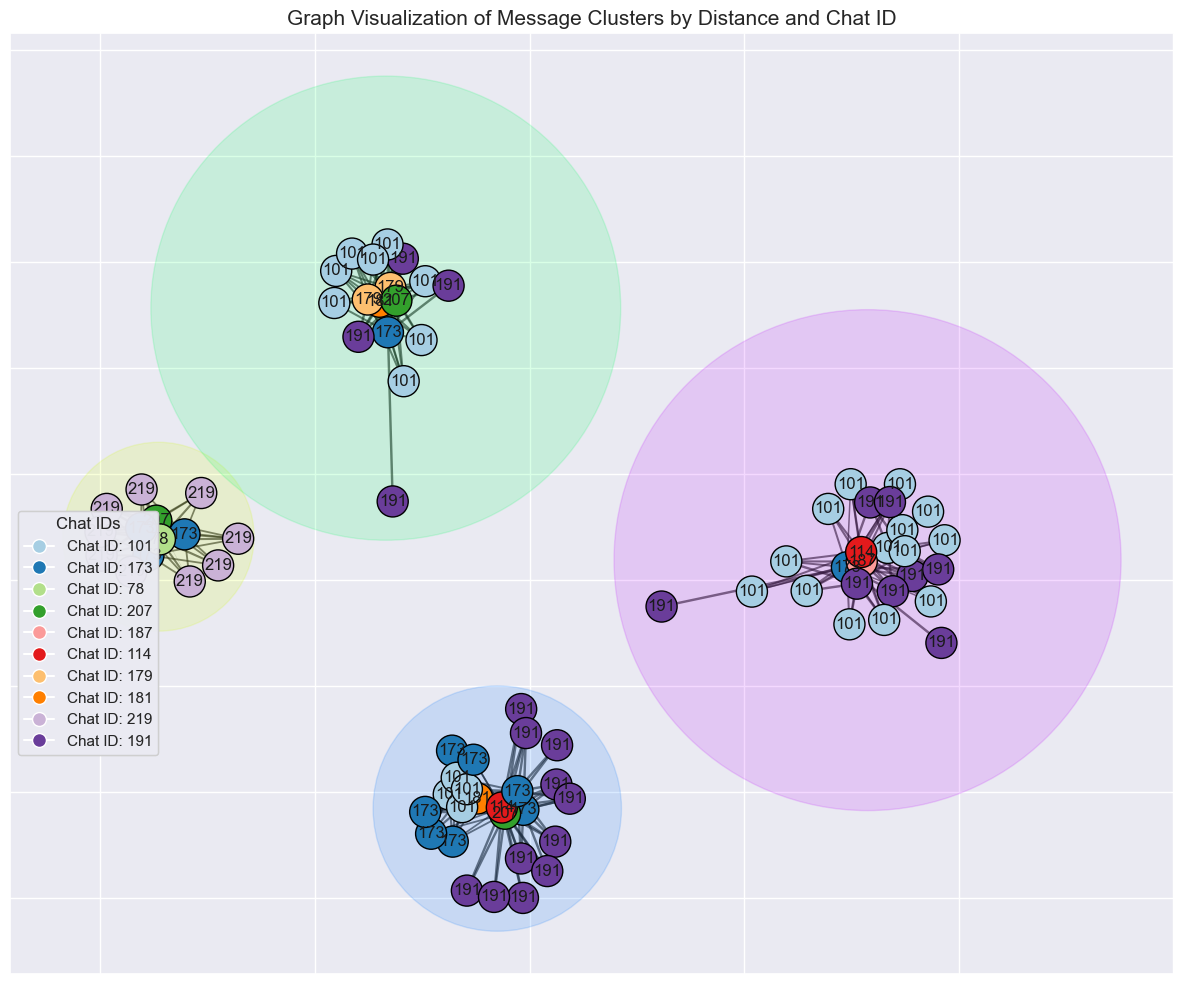

4

In [76]:
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 40) & (clusters_compare_df['c_id'].value_counts() < 100)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]


plot_clusters(test_clusters, 0.3)

# count the number of clusters intest_clusters
test_clusters['c_id'].nunique()

In [77]:
check_sim_clusters(test_clusters, [0,1])

 --- 18-5 ---
Similarity: 0.932779098960887
_____________________________________________________________________________________________________
Chat ID: 219                                       | Chat ID: 173                                      
#btcusdt↵                                          | #ethusdt↵                                         
short↵                                             | short↵                                            
leverage : cross 20x↵                              | leverage : cross 20x↵                             
entry : 16703.04 - 17204.1312↵                     | entry : 1209.81 - 1246.1043↵                      
target 1 : 16612.84358↵                            | target 1 : 1203.27702↵                            
target 2 : 16485.90048↵                            | target 2 : 1194.08247↵                            
target 3 : 16285.464↵                              | target 3 : 1179.56475↵                            
target 4 : 16168.54272

## Canales relacionados

In [78]:
import pandas as pd

def channel_corr_metrics(df_comp_cluster):
    # filter df_comp where chat_id_1 == chat_id_2
    flt = df_comp_cluster['chat_id_1'] != df_comp_cluster['chat_id_2']
    df_comp_cluster = df_comp_cluster[flt].copy()

    # add a column id_low with the lower id between chat_id_1 and chat_id_2
    df_comp_cluster['id_low'] = df_comp_cluster.apply(lambda x: min(x['chat_id_1'], x['chat_id_2']), axis=1)
    # add a column id_low with the max id between chat_id_1 and chat_id_2
    df_comp_cluster['id_high'] = df_comp_cluster.apply(lambda x: max(x['chat_id_1'], x['chat_id_2']), axis=1)

    # get the number of messages group by id_low and id_high, also average and meadian distance and similarity and number of clusters(c_id)
    chats_data = df_comp_cluster.groupby(['id_low', 'id_high']).agg({
        # 'distance': ['mean', 'median', 'min', 'max'],
        'similarity': ['mean', 'median', 'min', 'max', 'sum'],
        'c_id': 'nunique',
        'id_1': 'count'
    }).reset_index()

    # rename the columns
    chats_data.columns = ['id_low', 'id_high',
                        # 'avg_distance', 'median_distance', 'min_distance', 'max_distance',
                          'avg_sim', 'median_sim', 'min_sim', 'max_sim', 'sum_sim', 
                          'num_clusters', 'num_messages']


    # group by id_low, id_high and c_id, get the avg and median of similarity and distance, also number of items
    cluster_data = df_comp_cluster.groupby(['id_low', 'id_high', 'c_id']).agg({
        # 'distance': ['mean', 'median'],
        'similarity': ['mean', 'median'],
        'c_id': 'count'
    }).reset_index()

    # rename the columns
    cluster_data.columns = ['id_low', 'id_high', 'c_id', 
                            'avg_sim', 'median_sim',
                            'cluster_size']

    
    # group cluster_data by id_low and id_high and get the avg and median of the cluster_size
    cluster_size_data = cluster_data.groupby(['id_low', 'id_high']).agg({
        'cluster_size': ['mean', 'median'],
        'avg_sim': ['mean'],
        'median_sim': ['mean'],
    }).reset_index()

    # rename the columns

    cluster_size_data.columns = ['id_low', 'id_high', 
                                 'avg_cluster_size', 'median_cluster_size', 
                                 'avg_cl_avg_sim', 'avg_cl_median_sim']

    # merge chats_data with cluster_size_data
    channel_corr_data = pd.merge(chats_data, cluster_size_data, on=['id_low', 'id_high'], how='left')

    # sort by num_messages
    channel_corr_data = channel_corr_data.sort_values(by='num_messages', ascending=False)
    
    return channel_corr_data
    # return chats_data


# Example usage with the given df_comp DataFrame
channel_correlation_data = channel_corr_metrics(clusters_compare_df)






In [79]:
channel_correlation_data = channel_correlation_data.sort_values(by='sum_sim', ascending=False)
# channel_correlation_data.head(30).tail(20)
channel_correlation_data.head(10).tail(20)[['id_low','id_high', 'num_messages', 'sum_sim', 'median_sim']]

,id_low,id_high,num_messages,sum_sim,median_sim
12,101,173,3917,3472.988040,0.885175
19,101,219,1845,1617.254648,0.875236
0,78,101,582,501.024259,0.857485
13,101,179,445,393.353549,0.885006
17,101,207,377,316.958001,0.835198
10,101,114,278,249.458815,0.896087
15,101,187,242,215.865202,0.891214
32,173,187,80,72.198471,0.903580
37,173,219,67,62.131798,0.920055
20,114,173,46,42.770673,0.930863


In [80]:
# #filter df_comp by chat_id_1 == chat_id_a and chat_id_2 == chat_id_b and viceversa
# chat_id_a, chat_id_b = 173, 209

# flt = (df_comp['chat_id_1'] == chat_id_a) & (df_comp['chat_id_2'] == chat_id_b)
# flt = flt | ((df_comp['chat_id_1'] == chat_id_b) & (df_comp['chat_id_2'] == chat_id_a))

# df_comp[flt]

In [81]:
clusters_compare_df

,c_id,c_grp,sc_id,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance,chats-idx
1429,18-0,18,0,9569,8871,0.804037,coin : #dydx/usdt\nshort ( high risk)\nentry: ...,coin dydx usdt\nshort high risk\nentry {NUM} {...,78,2022-06-19 05:34:57+00:00,#storj/usdt long\nentry: 0.50 - 0.485\ntarget...,storj usdt long\nentry {NUM} {NUM}\ntarget {NU...,2077,2022-06-19 19:27:30+00:00,0.19596,2077-78
1430,18-0,18,0,9569,8886,0.816879,coin : #dydx/usdt\nshort ( high risk)\nentry: ...,coin dydx usdt\nshort high risk\nentry {NUM} {...,78,2022-06-19 05:34:57+00:00,#trb/usdt short\nentry: 11.05 - 11.35\ntarget...,trb usdt short\nentry {NUM} {NUM}\ntarget {NUM...,2077,2022-06-22 06:04:39+00:00,0.18312,2077-78
1431,18-0,18,0,9569,8887,0.814248,coin : #dydx/usdt\nshort ( high risk)\nentry: ...,coin dydx usdt\nshort high risk\nentry {NUM} {...,78,2022-06-19 05:34:57+00:00,#mana/usdt long\nentry: 0.898 - 0.872\ntarget...,mana usdt long\nentry {NUM} {NUM}\ntarget {NUM...,2077,2022-06-22 06:01:43+00:00,0.18575,2077-78
1432,18-0,18,0,8886,414,0.876840,#trb/usdt short\nentry: 11.05 - 11.35\ntarget...,trb usdt short\nentry {NUM} {NUM}\ntarget {NUM...,2077,2022-06-22 06:04:39+00:00,maskusdt\nlong\nleverage : cross 20x\nentry : ...,maskusdt\nlong\nleverage cross 20x\nentry {NUM...,181,2022-10-14 14:02:25+00:00,0.12316,181-2077
1433,18-0,18,0,414,8887,0.891253,maskusdt\nlong\nleverage : cross 20x\nentry : ...,maskusdt\nlong\nleverage cross 20x\nentry {NUM...,181,2022-10-14 14:02:25+00:00,#mana/usdt long\nentry: 0.898 - 0.872\ntarget...,mana usdt long\nentry {NUM} {NUM}\ntarget {NUM...,2077,2022-06-22 06:01:43+00:00,0.10875,181-2077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92995,19-12,19,12,1739,6278,0.864071,roseusdt\nshort\nentry: 0.04479-0.0461337\nlev...,roseusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,219,2022-11-28 10:00:50+00:00,ccf\npair : chzusdt\nlong\nleverage : cross 20...,ccf\npair chzusdt\nlong\nleverage cross 20x\ne...,101,2022-11-21 23:15:02+00:00,0.13593,101-219
93071,19-12,19,12,11436,13468,0.883655,ccf\npair : tlmusdt\nlong\nleverage : cross 20...,ccf\npair tlmusdt\nlong\nleverage cross 20x\ne...,101,2022-11-21 05:30:03+00:00,grtusdt\nshort\nentry: 0.0607-0.062521\nlevera...,grtusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,219,2022-11-28 11:01:52+00:00,0.11635,101-219
93076,19-12,19,12,4624,13468,0.884476,ccf\npair : ltcusdt\nlong\nleverage : cross 20...,ccf\npair ltcusdt\nlong\nleverage cross 20x\ne...,101,2022-11-25 03:48:00+00:00,grtusdt\nshort\nentry: 0.0607-0.062521\nlevera...,grtusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,219,2022-11-28 11:01:52+00:00,0.11552,101-219
93091,19-12,19,12,10936,1739,0.871757,ccf\npair : apeusdt\nshort\nleverage : cross 2...,ccf\npair apeusdt\nshort\nleverage cross 20x\n...,101,2022-11-17 23:20:07+00:00,roseusdt\nshort\nentry: 0.04479-0.0461337\nlev...,roseusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,219,2022-11-28 10:00:50+00:00,0.12824,101-219


In [82]:
check_sim_chats(clusters_compare_df, 101, 173, width=50)

 --- 19-1 ---
Similarity: 0.8944385520890682
_____________________________________________________________________________________________________
Chat ID: 173                                       | Chat ID: 101                                      
Msg ID: 4201 - Fecha: 2022-10-07 21:01:58+00:00    | Msg ID: 2999 - Fecha: 2022-10-10 01:42:18+00:00   
-----------------------------------------------------------------------------------------------------
chzusdt↵                                           | ccf↵                                              
long↵                                              | pair : ethusdt↵                                   
entry: 0.2189-0.212333↵                            | long↵                                             
leverage: cross 25x↵                               | leverage : cross 20x↵                             
target 1 - 0.2199945↵                              | entry : 1333.47 - 1293.46589↵                     
target 2 - 0.2221835↵  

In [83]:
# get the unique values of chat_id and title
chat_id_title = df[['chat_id', 'telegram_user_id', 'title']].drop_duplicates()

# filter chat_id_title by chat_id in channel_correlation_data['id_low'] and channel_correlation_data['id_high']
flt = chat_id_title['chat_id'].isin(channel_correlation_data['id_low']) | chat_id_title['chat_id'].isin(channel_correlation_data['id_high'])
chat_id_title = chat_id_title[flt]

# filter by chat id in [1,3]
flt = chat_id_title['chat_id'].isin([173, 207, 219, 101, 1735, 1751])
chat_id_title[flt]

,chat_id,telegram_user_id,title
7147,101,CryptoCashFlowReal,Crypto Cash flow
9892,173,Bitstamp_1,BITSTAMP SIGNALS ®️
11608,207,NaN,Cryptotegic™
11815,219,Zignaly00,Zignaly Crypto Signals ®


### Clusters por metricas de chats

In [84]:
df_comp_src 
flt = df_comp_src['similarity'] > 0.91
df_comp_chat_metrics = df_comp_src[flt].copy()

In [85]:
# Add a column with datetime difference in hours
df_comp_chat_metrics['date_id_1'] = pd.to_datetime(df_comp_chat_metrics['date_id_1'])
df_comp_chat_metrics['date_id_2'] = pd.to_datetime(df_comp_chat_metrics['date_id_2'])
df_comp_chat_metrics['date_diff'] = df_comp_chat_metrics['date_id_2'] - df_comp_chat_metrics['date_id_1']
df_comp_chat_metrics['date_diff_hours'] = df_comp_chat_metrics['date_diff'].dt.total_seconds() / 3600

# add a column with date_id_1 rounded to the nearest hour
df_comp_chat_metrics['date_id_1_round'] = df_comp_chat_metrics['date_id_1'].dt.round('H')


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_69704/1902630953.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_comp_chat_metrics['date_id_1_round'] = df_comp_chat_metrics['date_id_1'].dt.round('H')


In [86]:
df_comp_chat_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 15628 to 25791
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                912 non-null    int64              
 1   word_bin                   912 non-null    int64              
 2   trade_type                 912 non-null    object             
 3   id_1                       912 non-null    int64              
 4   id_2                       912 non-null    int64              
 5   similarity                 912 non-null    float64            
 6   message_text_clean_utf8_1  912 non-null    object             
 7   cleaned_sim_1              912 non-null    object             
 8   chat_id_1                  912 non-null    int64              
 9   date_id_1                  912 non-null    datetime64[ns, UTC]
 10  message_text_clean_utf8_2  912 non-null    object             
 11  clean

In [87]:
df_comp_chat_metrics['idx_chats']   = df_comp_chat_metrics.apply(lambda x: '-'.join(sorted([str(x['chat_id_1']), str(x['chat_id_2'])])), axis=1)

In [88]:
# group by chat_id_1, chat_id_2, date_id_1_round and get the count of messages, the sum of similarity and the mean of distance
df_comp_grouped = df_comp_chat_metrics.groupby(['idx_chats']).agg({
    'id_1': ['count', 'nunique'],
    'id_2': ['nunique'],
    'similarity': ['sum', 'mean'],
    'distance': ['sum', 'mean'],
    'date_diff_hours': ['sum', 'mean']
}).reset_index()

# rename the columns df_comp_grouped Count -> num_messages, similarity -> sum_similarity, distance -> avg_distance
df_comp_grouped.columns = ['idx_chats', 
                           'num_messages_pairs', 'msgs_chat_id_1', 'msgs_chat_id_2',
                           'sum_similarity', 'avg_similarity',
                           'sum_distance', 'avg_distance',
                           'sum_date_diff_hours', 'avg_date_diff_hours',
                           ]

df_comp_grouped3 = df_comp_grouped.sort_values(by='idx_chats')

# add column msg_ratio with the ratio of max of(msgs_chat_id_1 and msgs_chat_id_2) and min of(msgs_chat_id_1 and msgs_chat_id_2)
df_comp_grouped['msg_ratio'] = df_comp_grouped.apply(lambda x: max(x['msgs_chat_id_1'], x['msgs_chat_id_2']) / min(x['msgs_chat_id_1'], x['msgs_chat_id_2']), axis=1)

cols = ['idx_chats',
        'num_messages_pairs', 'msgs_chat_id_1', 'msgs_chat_id_2',
        'msg_ratio', 'sum_similarity', 'avg_similarity',
        'sum_distance', 'avg_distance', 'sum_date_diff_hours', 'avg_date_diff_hours']
df_comp_grouped[cols]

,idx_chats,num_messages_pairs,msgs_chat_id_1,msgs_chat_id_2,msg_ratio,sum_similarity,avg_similarity,sum_distance,avg_distance,sum_date_diff_hours,avg_date_diff_hours
0,101-114,26,19,11,1.727273,24.416039,0.939078,1.58401,0.060923,2176.541389,83.713130
1,101-173,126,66,54,1.222222,119.739400,0.950313,6.26066,0.049688,10518.670278,83.481510
2,101-181,2,1,2,2.000000,1.910621,0.955311,0.08937,0.044685,216.535278,108.267639
3,101-219,25,22,7,3.142857,23.823661,0.952946,1.17634,0.047054,1849.501389,73.980056
4,114-173,92,51,40,1.275000,85.914356,0.933852,6.08568,0.066149,7167.105556,77.903321
...,...,...,...,...,...,...,...,...,...,...,...
50,3-67,1,1,1,1.000000,0.985312,0.985312,0.01469,0.014690,144.897778,144.897778
51,3689-3703,3,3,3,1.000000,3.000000,1.000000,0.00000,0.000000,0.010833,0.003611
52,3689-3741,2,2,2,1.000000,2.000000,1.000000,0.00000,0.000000,0.004167,0.002083
53,3703-3741,2,2,2,1.000000,2.000000,1.000000,0.00000,0.000000,0.004722,0.002361


In [89]:
df_comp_grouped['sim_ratio'] = df_comp_grouped['sum_similarity']/df_comp_grouped['msg_ratio']


In [101]:
# split idx_chats into chat_id_1 and chat_id_2
df_comp_grouped[['chat_id_low', 'chat_id_high']] = df_comp_grouped['idx_chats'].str.split('-', expand=True).astype(int)


In [102]:
# cols = ['idx_chats',
#         'num_messages_pairs', 'msgs_chat_id_1', 'msgs_chat_id_2',
#         'msg_ratio', 'sim_ratio',
#         'sum_similarity', 'avg_similarity',
#         'sum_distance', 'avg_distance', 'sum_date_diff_hours', 'avg_date_diff_hours']

cols = ['idx_chats',
        'num_messages_pairs', 'msgs_chat_id_1', 'msgs_chat_id_2',
        'msg_ratio', 'sim_ratio',
        'sum_similarity', 'avg_similarity']

df_comp_grouped[cols].sort_values(by='sim_ratio', ascending=False).head(10)

,idx_chats,num_messages_pairs,msgs_chat_id_1,msgs_chat_id_2,msg_ratio,sim_ratio,sum_similarity,avg_similarity
1,101-173,126,66,54,1.222222,97.968600,119.739400,0.950313
21,1730-1934,109,57,62,1.087719,95.183871,103.533333,0.949847
20,173-219,126,43,34,1.264706,92.684760,117.218962,0.930309
4,114-173,92,51,40,1.275000,67.383808,85.914356,0.933852
22,1735-1751,78,34,39,1.147059,64.553294,74.046426,0.949313
15,173-181,62,22,29,1.318182,43.994669,57.992973,0.935371
14,173-179,66,39,23,1.695652,36.206755,61.394062,0.930213
27,177-3389,25,14,13,1.076923,21.852528,23.533492,0.941340
16,173-187,20,11,14,1.272727,14.392525,18.317759,0.915888
17,173-207,21,11,15,1.363636,14.195280,19.357200,0.921771


In [103]:
df_comp_grouped

,idx_chats,num_messages_pairs,msgs_chat_id_1,msgs_chat_id_2,sum_similarity,avg_similarity,sum_distance,avg_distance,sum_date_diff_hours,avg_date_diff_hours,msg_ratio,sim_ratio,chat_id_low,chat_id_high
0,101-114,26,19,11,24.416039,0.939078,1.58401,0.060923,2176.541389,83.713130,1.727273,14.135601,101,114
1,101-173,126,66,54,119.739400,0.950313,6.26066,0.049688,10518.670278,83.481510,1.222222,97.968600,101,173
2,101-181,2,1,2,1.910621,0.955311,0.08937,0.044685,216.535278,108.267639,2.000000,0.955311,101,181
3,101-219,25,22,7,23.823661,0.952946,1.17634,0.047054,1849.501389,73.980056,3.142857,7.580256,101,219
4,114-173,92,51,40,85.914356,0.933852,6.08568,0.066149,7167.105556,77.903321,1.275000,67.383808,114,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,3-67,1,1,1,0.985312,0.985312,0.01469,0.014690,144.897778,144.897778,1.000000,0.985312,3,67
51,3689-3703,3,3,3,3.000000,1.000000,0.00000,0.000000,0.010833,0.003611,1.000000,3.000000,3689,3703
52,3689-3741,2,2,2,2.000000,1.000000,0.00000,0.000000,0.004167,0.002083,1.000000,2.000000,3689,3741
53,3703-3741,2,2,2,2.000000,1.000000,0.00000,0.000000,0.004722,0.002361,1.000000,2.000000,3703,3741


In [104]:
# filter by idx_chats in ['173-209', '173-209']
flt = df_comp_chat_metrics['idx_chats'].isin(['101-114'])
sub_grp = df_comp_chat_metrics[flt]


# get the unique values of id_1 from  sub_grp
id1 = sub_grp['id_1'].unique()
id2 = sub_grp['id_2'].unique()

print(id1)
print(len(id1))
print()
print(id2)
print(len(id2))






[ 4039  4111 11848  2923 11877  3737 11704  4011  2909  3509  2508  6679
  3304  8793  6505  8579 12542  9073  1572]
19

[ 2899   874  4039 11761 11838 11294  3815  3304 11159  2283 11398]
11


In [105]:
check_sim_chats(df_comp_chat_metrics, 101, 173, width=50, records=10, offset=0)

Similarity: 0.9604574273515849
_____________________________________________________________________________________________________
Chat ID: 101                                       | Chat ID: 173                                      
Msg ID: 6826 - Fecha: 2022-11-16 20:00:08+00:00    | Msg ID: 7015 - Fecha: 2022-11-19 19:00:24+00:00   
-----------------------------------------------------------------------------------------------------
ccf↵                                               | maskusdt↵                                         
pair : maskusdt↵                                   | short↵                                            
short↵                                             | entry: 2.883-2.96949↵                             
leverage : cross 20x↵                              | leverage: cross 25x↵                              
entry : 3.146 - 3.24038↵                           | target 1 - 2.868585↵                              
target 1 : 3.12901↵                  

In [106]:
check_sim_chats(df_comp_chat_metrics, 173, 219, width=50)


Similarity: 1.0000000000000002
_____________________________________________________________________________________________________
Chat ID: 219                                       | Chat ID: 173                                      
Msg ID: 13626 - Fecha: 2022-11-11 18:05:29+00:00   | Msg ID: 13630 - Fecha: 2022-11-11 18:06:00+00:00  
-----------------------------------------------------------------------------------------------------
#axsusdt↵                                          | #axsusdt↵                                         
long↵                                              | long↵                                             
leverage : cross 20x↵                              | leverage : cross 20x↵                             
entry : 6.88 - 6.6048↵                             | entry : 6.88 - 6.6048↵                            
target 1 : 6.93504↵                                | target 1 : 6.93504↵                               
target 2 : 7.01072↵                  

In [107]:

def plot_clusters2(df_clusters, k=0.3):
    # Create a graph
    G = nx.Graph()
    # Add edges with weights based on distance and assign the cluster id
    for _, row in df_clusters.iterrows():
        if row['id_1'] not in G.nodes:
            G.add_node(row['id_1'], chat_id=row['chat_id_1'], label=row['chat_id_1'])

        if row['id_2'] not in G.nodes:
            G.add_node(row['id_2'], chat_id=row['chat_id_2'], label=row['chat_id_2'])

        # G.add_edge(row['id_1'], row['id_2'], weight=(row['distance']** (1/3))*3)
        G.add_edge(row['id_1'], row['id_2'], weight=(row['distance']))

    # Get unique clusters and define colors
    # unique_clusters = df_clusters['c_id'].unique()
    # palette = sns.color_palette('hsv', len(unique_clusters))
    # cluster_colors = {c_id: palette[i] for i, c_id in enumerate(unique_clusters)}

    # Get unique chat_id and define colors
    unique_chat_id1 = df_clusters['chat_id_1'].unique()
    unique_chat_id2 = df_clusters['chat_id_2'].unique()
    # Merge chat_id1 and chat_id2
    unique_chat_id = list(set(list(unique_chat_id1) + list(unique_chat_id2)))
    palette_chat_id = sns.color_palette('Paired', len(unique_chat_id))
    chat_id_colors = {unique_chat_id[i]: palette for i, palette in enumerate(palette_chat_id)}

    # Generate positions for each node with increased `k` to separate clusters
    pos = nx.spring_layout(G, seed=42, k=k)  # Increase `k` for more separation between clusters

    # Plot the graph
    plt.figure(figsize=(12, 10))
    axes = plt.gca()

    # Draw edges with widths based on distance
    
    edges_in_cluster = [(u, v) for u, v, d in G.edges(data=True)]
    similarities = [G[u][v]['weight'] for u, v in edges_in_cluster]
    widths = [d if d > 0.1 else 0.1 for d in similarities]
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_cluster, width=widths, alpha=0.6)

    # Draw nodes with colors based on their chat_id
    node_colors = [chat_id_colors[G.nodes[n]['chat_id']] if 'chat_id' in G.nodes[n] else 'lightblue' for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, edgecolors='black')


    # Draw labels for the nodes
    labels = nx.get_node_attributes(G, 'chat_id')  # get labels 
    nx.draw_networkx_labels(G, pos, font_size=12, labels=labels)


    # Create a legend for the chat_id colors
    chat_legend = [plt.Line2D([0], [0], marker='o', color='w', label=f'Chat ID: {chat_id}',
                            markerfacecolor=chat_id_colors[chat_id], markersize=10, alpha=1) for chat_id in unique_chat_id]

    legend1 = plt.legend(handles=chat_legend, title="Chat IDs", loc='upper left', bbox_to_anchor=(0, 0.5))

    # axes.add_artist(legend2)
    axes.add_artist(legend1)

    plt.title('Graph Visualization of Message Clusters by Distance and Chat ID', size=15)
    plt.tight_layout()

    plt.show()


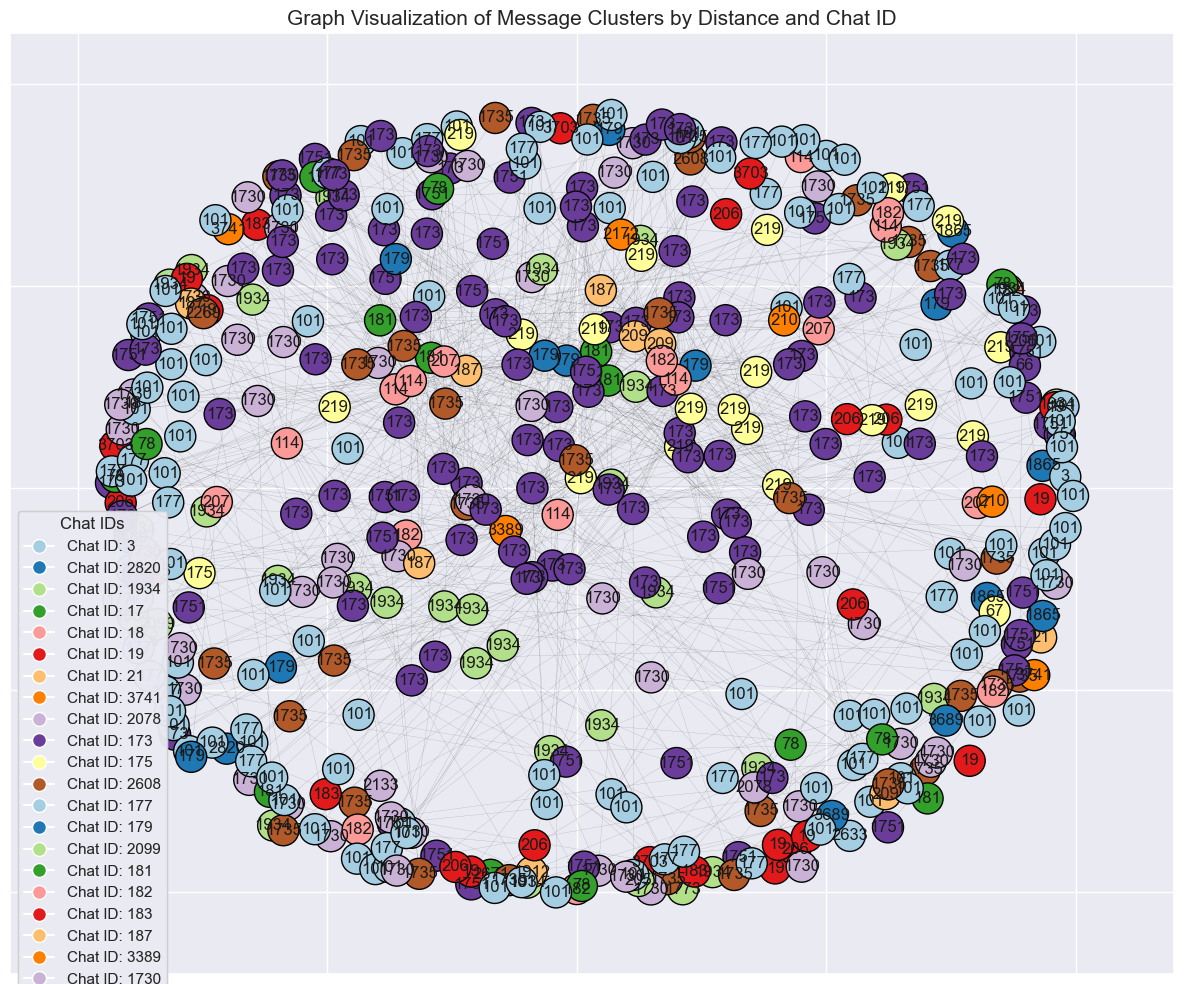

In [108]:
plot_clusters2(df_comp_chat_metrics, k=0.2)

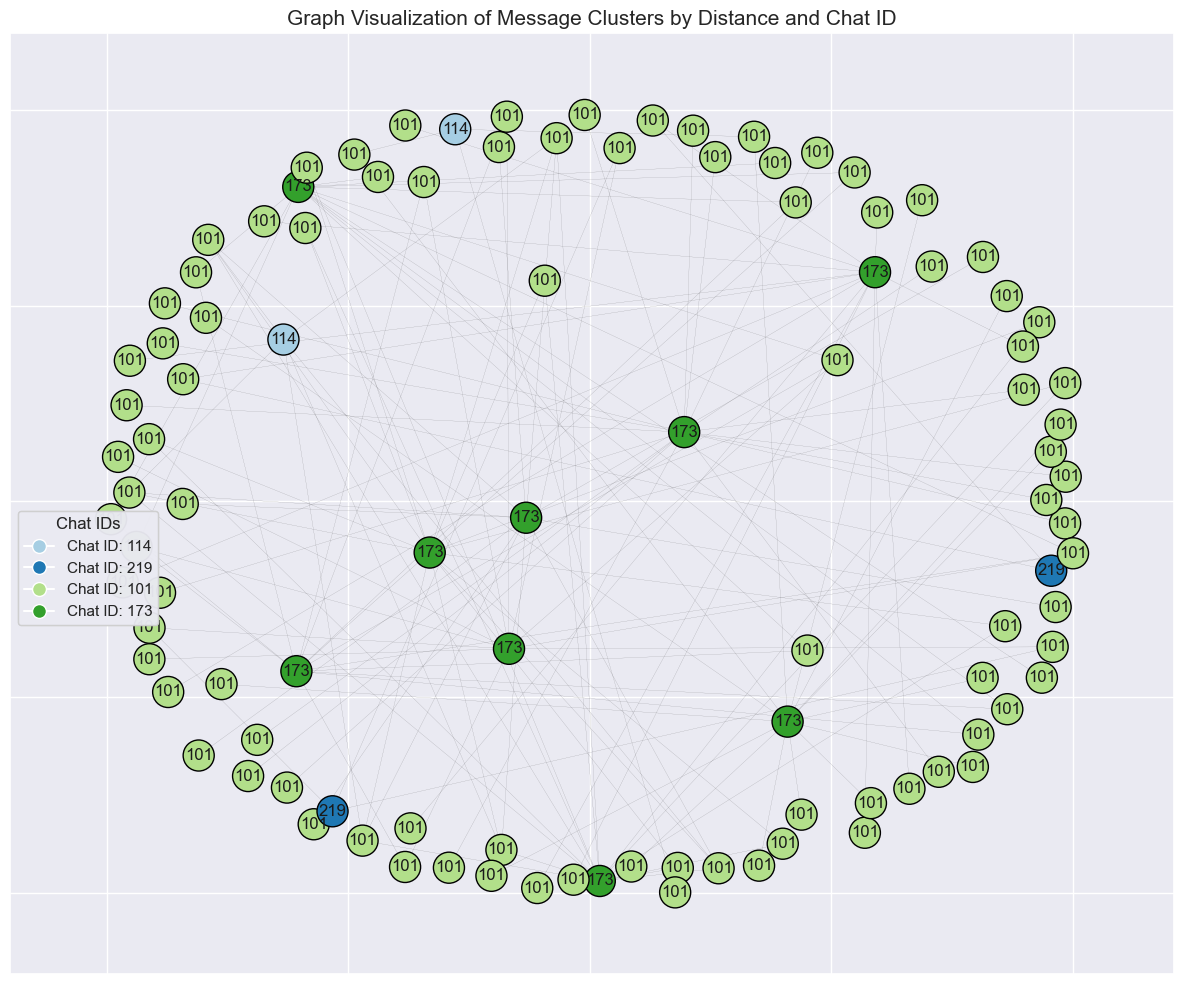

In [120]:
# df_comp_grouped_flt = df_comp_grouped[df_comp_grouped['num_messages_pairs'] >= 100]
flt = (df_comp_grouped['idx_chats'] == '101-173')
df_comp_grouped_flt = df_comp_grouped[flt]

#filter df_comp_chat_metrics_flt where chat_id_1  and chat_id_2 are in df_comp_grouped2 id_low and id_high
flt =       df_comp_chat_metrics['chat_id_1'].isin(df_comp_grouped_flt['chat_id_low'])  | df_comp_chat_metrics['chat_id_1'].isin(df_comp_grouped_flt['chat_id_high'])
flt = flt & df_comp_chat_metrics['chat_id_2'].isin(df_comp_grouped_flt['chat_id_high']) | df_comp_chat_metrics['chat_id_2'].isin(df_comp_grouped_flt['chat_id_low'])

df_comp_chat_metrics_flt = df_comp_chat_metrics[flt]



plot_clusters2(df_comp_chat_metrics_flt, k=0.7)

In [112]:
df_comp_grouped

,idx_chats,num_messages_pairs,msgs_chat_id_1,msgs_chat_id_2,sum_similarity,avg_similarity,sum_distance,avg_distance,sum_date_diff_hours,avg_date_diff_hours,msg_ratio,sim_ratio,chat_id_low,chat_id_high
0,101-114,26,19,11,24.416039,0.939078,1.58401,0.060923,2176.541389,83.713130,1.727273,14.135601,101,114
1,101-173,126,66,54,119.739400,0.950313,6.26066,0.049688,10518.670278,83.481510,1.222222,97.968600,101,173
2,101-181,2,1,2,1.910621,0.955311,0.08937,0.044685,216.535278,108.267639,2.000000,0.955311,101,181
3,101-219,25,22,7,23.823661,0.952946,1.17634,0.047054,1849.501389,73.980056,3.142857,7.580256,101,219
4,114-173,92,51,40,85.914356,0.933852,6.08568,0.066149,7167.105556,77.903321,1.275000,67.383808,114,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,3-67,1,1,1,0.985312,0.985312,0.01469,0.014690,144.897778,144.897778,1.000000,0.985312,3,67
51,3689-3703,3,3,3,3.000000,1.000000,0.00000,0.000000,0.010833,0.003611,1.000000,3.000000,3689,3703
52,3689-3741,2,2,2,2.000000,1.000000,0.00000,0.000000,0.004167,0.002083,1.000000,2.000000,3689,3741
53,3703-3741,2,2,2,2.000000,1.000000,0.00000,0.000000,0.004722,0.002361,1.000000,2.000000,3703,3741


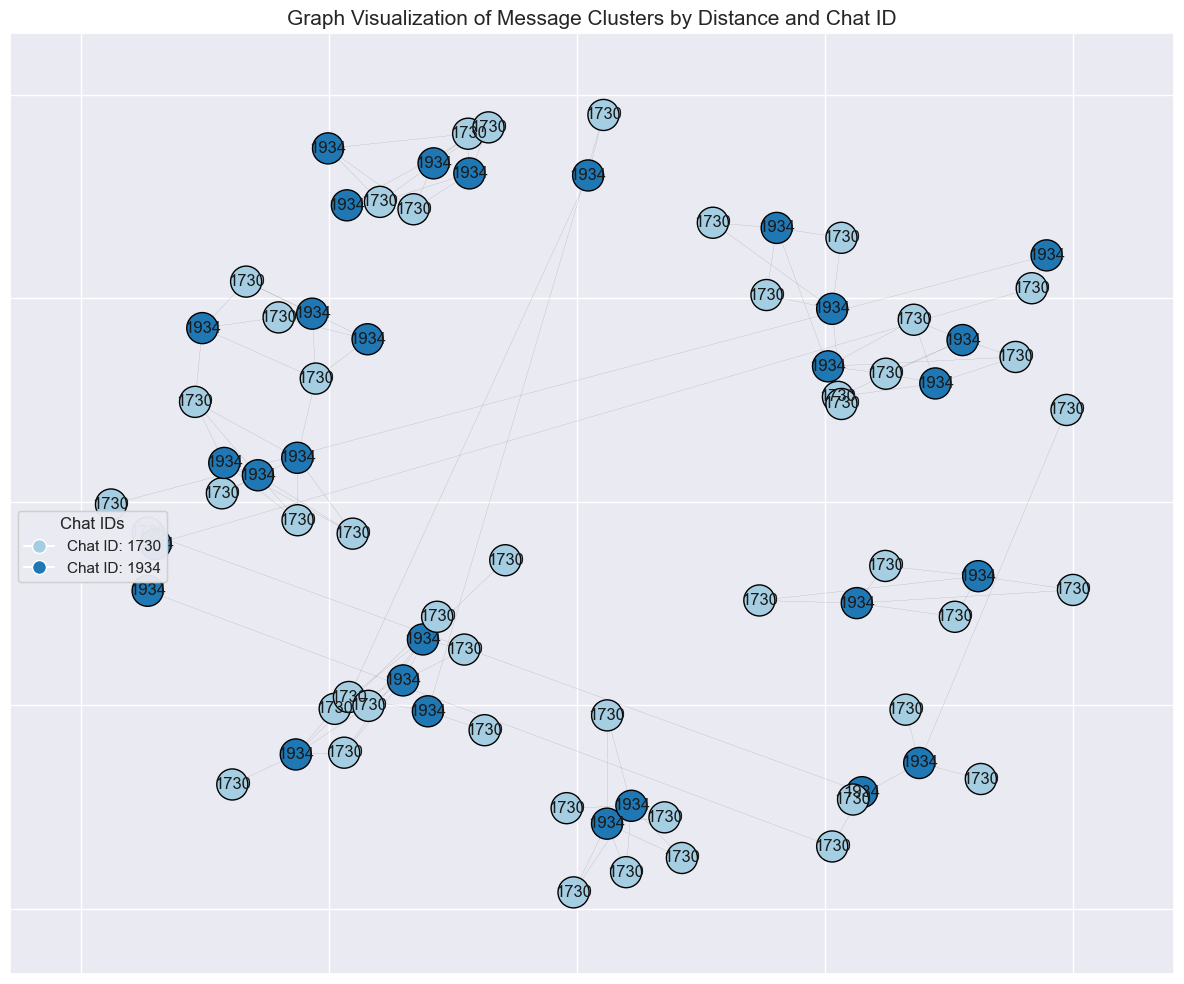

,idx_chats,num_messages_pairs,msgs_chat_id_1,msgs_chat_id_2,sum_similarity,avg_similarity,sum_distance,avg_distance,sum_date_diff_hours,avg_date_diff_hours,msg_ratio,sim_ratio,chat_id_low,chat_id_high
21,1730-1934,109,57,62,103.533333,0.949847,5.46667,0.050153,5348.051389,49.064692,1.087719,95.183871,1730,1934


In [123]:
# 101-173
# 1730-1934
# 173-219

flt = (df_comp_grouped['idx_chats'] == '1730-1934')
df_comp_grouped_flt = df_comp_grouped[flt]

#filter df_comp_chat_metrics_flt where chat_id_1  and chat_id_2 are in df_comp_grouped2 id_low and id_high
flt =       df_comp_chat_metrics['chat_id_1'].isin(df_comp_grouped_flt['chat_id_low'])  | df_comp_chat_metrics['chat_id_1'].isin(df_comp_grouped_flt['chat_id_high'])
flt = flt & df_comp_chat_metrics['chat_id_2'].isin(df_comp_grouped_flt['chat_id_high']) | df_comp_chat_metrics['chat_id_2'].isin(df_comp_grouped_flt['chat_id_low'])

df_comp_chat_metrics_flt = df_comp_chat_metrics[flt]


plot_clusters2(df_comp_chat_metrics_flt, k=0.1)
df_comp_grouped_flt
